In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }

quiet_library(hise)
quiet_library(data.table)
quiet_library(ggplot2)
quiet_library(dplyr)
quiet_library(purrr)

In [2]:
cache_path_uuid <- function(uuid) {
    cache_dir = paste0('cache/', uuid)
    if (!dir.exists(cache_dir)) {
        cacheFiles(list(uuid))
    }
    list.files(cache_dir, full.names = TRUE)
}

## Cell type hierarchy

In [3]:
hierarchy_uuid = "1a44252c-8cab-4c8f-92c9-d8f3af633790"
hierarchy_path = cache_path_uuid(hierarchy_uuid)
hierarchy_df = read.csv(hierarchy_path, row.names = 1)

In [4]:
l1_levels <- unique(hierarchy_df$AIFI_L1)
l2_levels <- unique(hierarchy_df$AIFI_L2)
l3_levels <- unique(hierarchy_df$AIFI_L3)

## Previous, non-tracked version of cell labels

We previously performed cell labeling in a way that wasn't tracked in our CertPro system. We'll compare our new results to these original results and make sure they're similar.

In [5]:
label_uuid <- "3868592c-0087-4ed8-98b2-4bf1b8676111"
res <- cacheFiles(list(label_uuid))
label_parquet <- list.files(paste0("cache/",label_uuid), full.names = TRUE)
label_csv <- sub("parquet","csv",label_parquet)
label_csv <- basename(label_csv)

Convert from parquet to csv for easy reading in R because our IDEs are having trouble with the `arrow` package:

In [6]:
system_call <- paste0(
    "python -c \'",
    "import pandas; ",
    "df = pandas.read_parquet(\"",label_parquet,"\");",
    "df = df[[\"barcodes\",\"AIFI_L1\",\"AIFI_L2\",\"AIFI_L3\"]];",
    "df.to_csv(\"",label_csv,"\")",
    "\'"
)

In [7]:
system_call

[1] "python -c 'import pandas; df = pandas.read_parquet(\"cache/3868592c-0087-4ed8-98b2-4bf1b8676111/all_imm_health_obs.parquet\");df = df[[\"barcodes\",\"AIFI_L1\",\"AIFI_L2\",\"AIFI_L3\"]];df.to_csv(\"all_imm_health_obs.csv\")'"

In [8]:
if(!file.exists("all_imm_health_obs.csv")) {
    system(system_call)
}

Python version information in case we need it for reproducibility:

In [9]:
system("python --version", intern = TRUE)

[1] "Python 3.10.13"

In [10]:
system("python -c 'import pandas; print(pandas.__version__)'", intern = TRUE)

[1] "2.1.4"

In [11]:
og_labels <- fread(label_csv, header = TRUE)
og_labels <- og_labels[,V1:=NULL]

In [12]:
og_labels <- as.data.frame(og_labels)

In [13]:
names(og_labels) <- sub("AIFI", "original", names(og_labels))

In [14]:
nrow(og_labels)

[1] 13846464

In [15]:
head(og_labels)

barcodes                         original_L1 original_L2 original_L3
1 05ea9806794211eb93b836d1cb6129eb DC          cDC1        cDC1       
2 e225c914794011eb9282e2ceeb91ba52 DC          cDC1        cDC1       
3 b1379eae795411eb958b0245821e6993 DC          cDC1        cDC1       
4 b13d3a8a795411eb958b0245821e6993 DC          cDC1        cDC1       
5 b1430d16795411eb958b0245821e6993 DC          cDC1        cDC1       
6 7f926876794e11eb80b0ca7613f64db1 DC          cDC1        cDC1

## Read metadata from AIFI_L3 label refinement

In [16]:
meta_uuids <- list(
    asdc = 'cce70b23-5728-4588-963e-8f0afafa3943',
    b_memory_cells = 'a712dc74-43b3-4dff-927e-d018dd369f9b',
    b_naive_cells = '3a1b1129-65ca-4f17-bc0f-2a53ac2ae963',
    dc = '63287a4b-adf0-42fc-8a75-37223d2f97de',
    gdt_cd8aa = 'cd513dd2-a72f-48e6-85b7-bad4676cb13f',
    treg = 'aab9cd47-29cd-4be4-bb86-2ed511b3d4e2',
    progen_prolif = '8226e775-8f4d-452e-b81e-3f3fb4a70d1e',
    eryth_platelet = 'e5c881d6-0576-4067-b624-4e984fe97900',
    plasma_ilc = 'b3636d73-58c9-4972-8fb9-1cb51439c377',
    dnt_mait = '4ce56aca-03a9-46b2-9a32-924a35602fce',
    cd8_naive = '45668c5c-1a48-4fae-9d59-fa566063263e',
    nk_cell = 'cd88f3f5-d0a3-4fc5-8b23-0000809c7a03',
    memory_cd4_t_cell = '83ddbc6b-e19a-4fb2-ba63-15af4cfc9a23',
    monocyte = '753055b8-d269-4980-a07d-69a14669d090',
    naive_cd4_t_cell = '3dda2996-1827-4422-a899-be5ec9ca52d2',
    memory_cd8_t_cell = '289bd005-09a1-4cad-8b8f-15165b61f590'
)

In [17]:
meta_paths <- map(meta_uuids, cache_path_uuid)

In [18]:
meta_dts <- map(meta_paths, fread)

In [19]:
all_meta <- map_dfr(meta_dts, as.data.frame)

In [20]:
nrow(all_meta)

[1] 14045942

## Correct Python category L3 labels

Rarely, our process in Python for refining cell labels results in ties between two cell types, and the full categorical information is stored as a string instead of a single cell type label.

These have the following structure:

`['cell_type_1', 'cell_type_2'] Categorical...`

We just want to extract the first cell type without quotes, which we can do using regular expressions:

In [21]:
all_meta <- all_meta %>%
  mutate(AIFI_L3 = sub("\\['", "", gsub("', .+","", AIFI_L3)))

Then, we need to update the L1 and L2 labels to match:

In [22]:
all_meta <- all_meta %>%
  select(-AIFI_L1, -AIFI_L2) %>%
  left_join(hierarchy_df, by = "AIFI_L3")

## Join previous labels

In [23]:
all_meta <- all_meta %>%
  left_join(og_labels, by = "barcodes")

## Fix missing back-propagation

In [24]:
missing_prop <- all_meta %>%
  filter(is.na(predicted_AIFI_L1))

missing_prop <- missing_prop %>%
  mutate(predicted_AIFI_L1 = AIFI_L1,
         predicted_AIFI_L2 = AIFI_L2) %>%
  select(-AIFI_L1, -AIFI_L2) %>%
  left_join(hierarchy_df, by = "AIFI_L3") %>%
  select(one_of(names(all_meta)))

all_meta <- all_meta %>%
  filter(!is.na(predicted_AIFI_L1)) %>%
  rbind(missing_prop)

## Compare original and updated label transfer at each level

### L1

In [25]:
l1_crosstab <- all_meta %>%
  group_by(predicted_AIFI_L1, original_L1) %>%
  tally() %>%
  group_by(predicted_AIFI_L1) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L1) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(predicted_AIFI_L1 = factor(predicted_AIFI_L1, levels = rev(l1_levels)),
         original_L1 = factor(original_L1, levels = l1_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

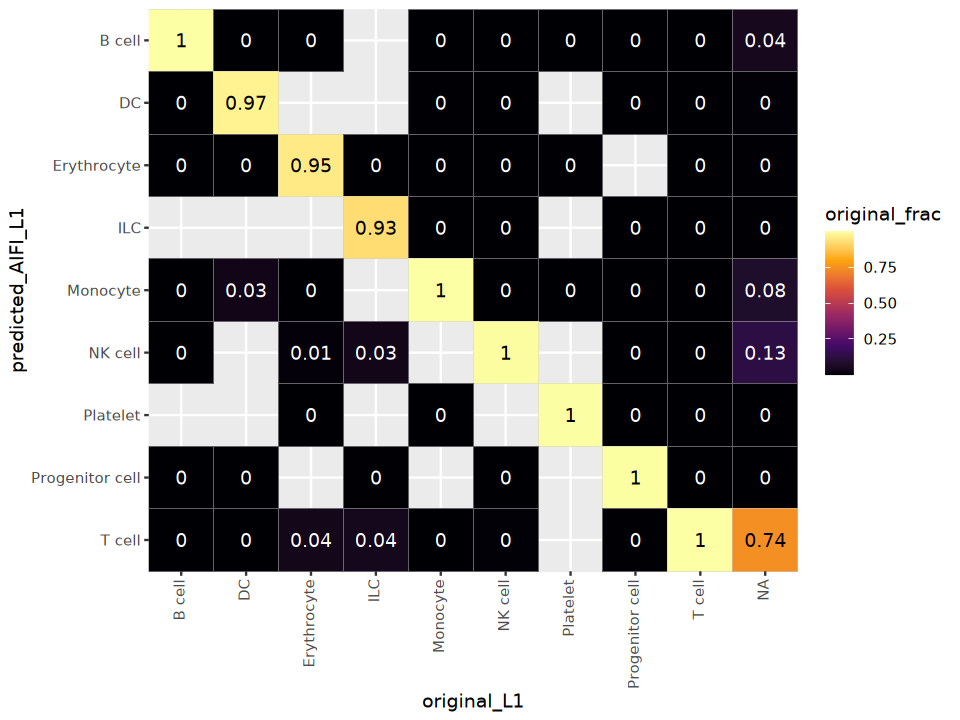

In [26]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() +
  geom_tile(
      data = l1_crosstab,
      aes(x = original_L1,
          y = predicted_AIFI_L1,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l1_crosstab,
      aes(x = original_L1,
          y = predicted_AIFI_L1,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L2

In [27]:
l2_crosstab <- all_meta %>%
  group_by(predicted_AIFI_L2, original_L2) %>%
  tally() %>%
  group_by(predicted_AIFI_L2) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L2) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(predicted_AIFI_L2 = factor(predicted_AIFI_L2, levels = rev(l2_levels)),
         original_L2 = factor(original_L2, levels = l2_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

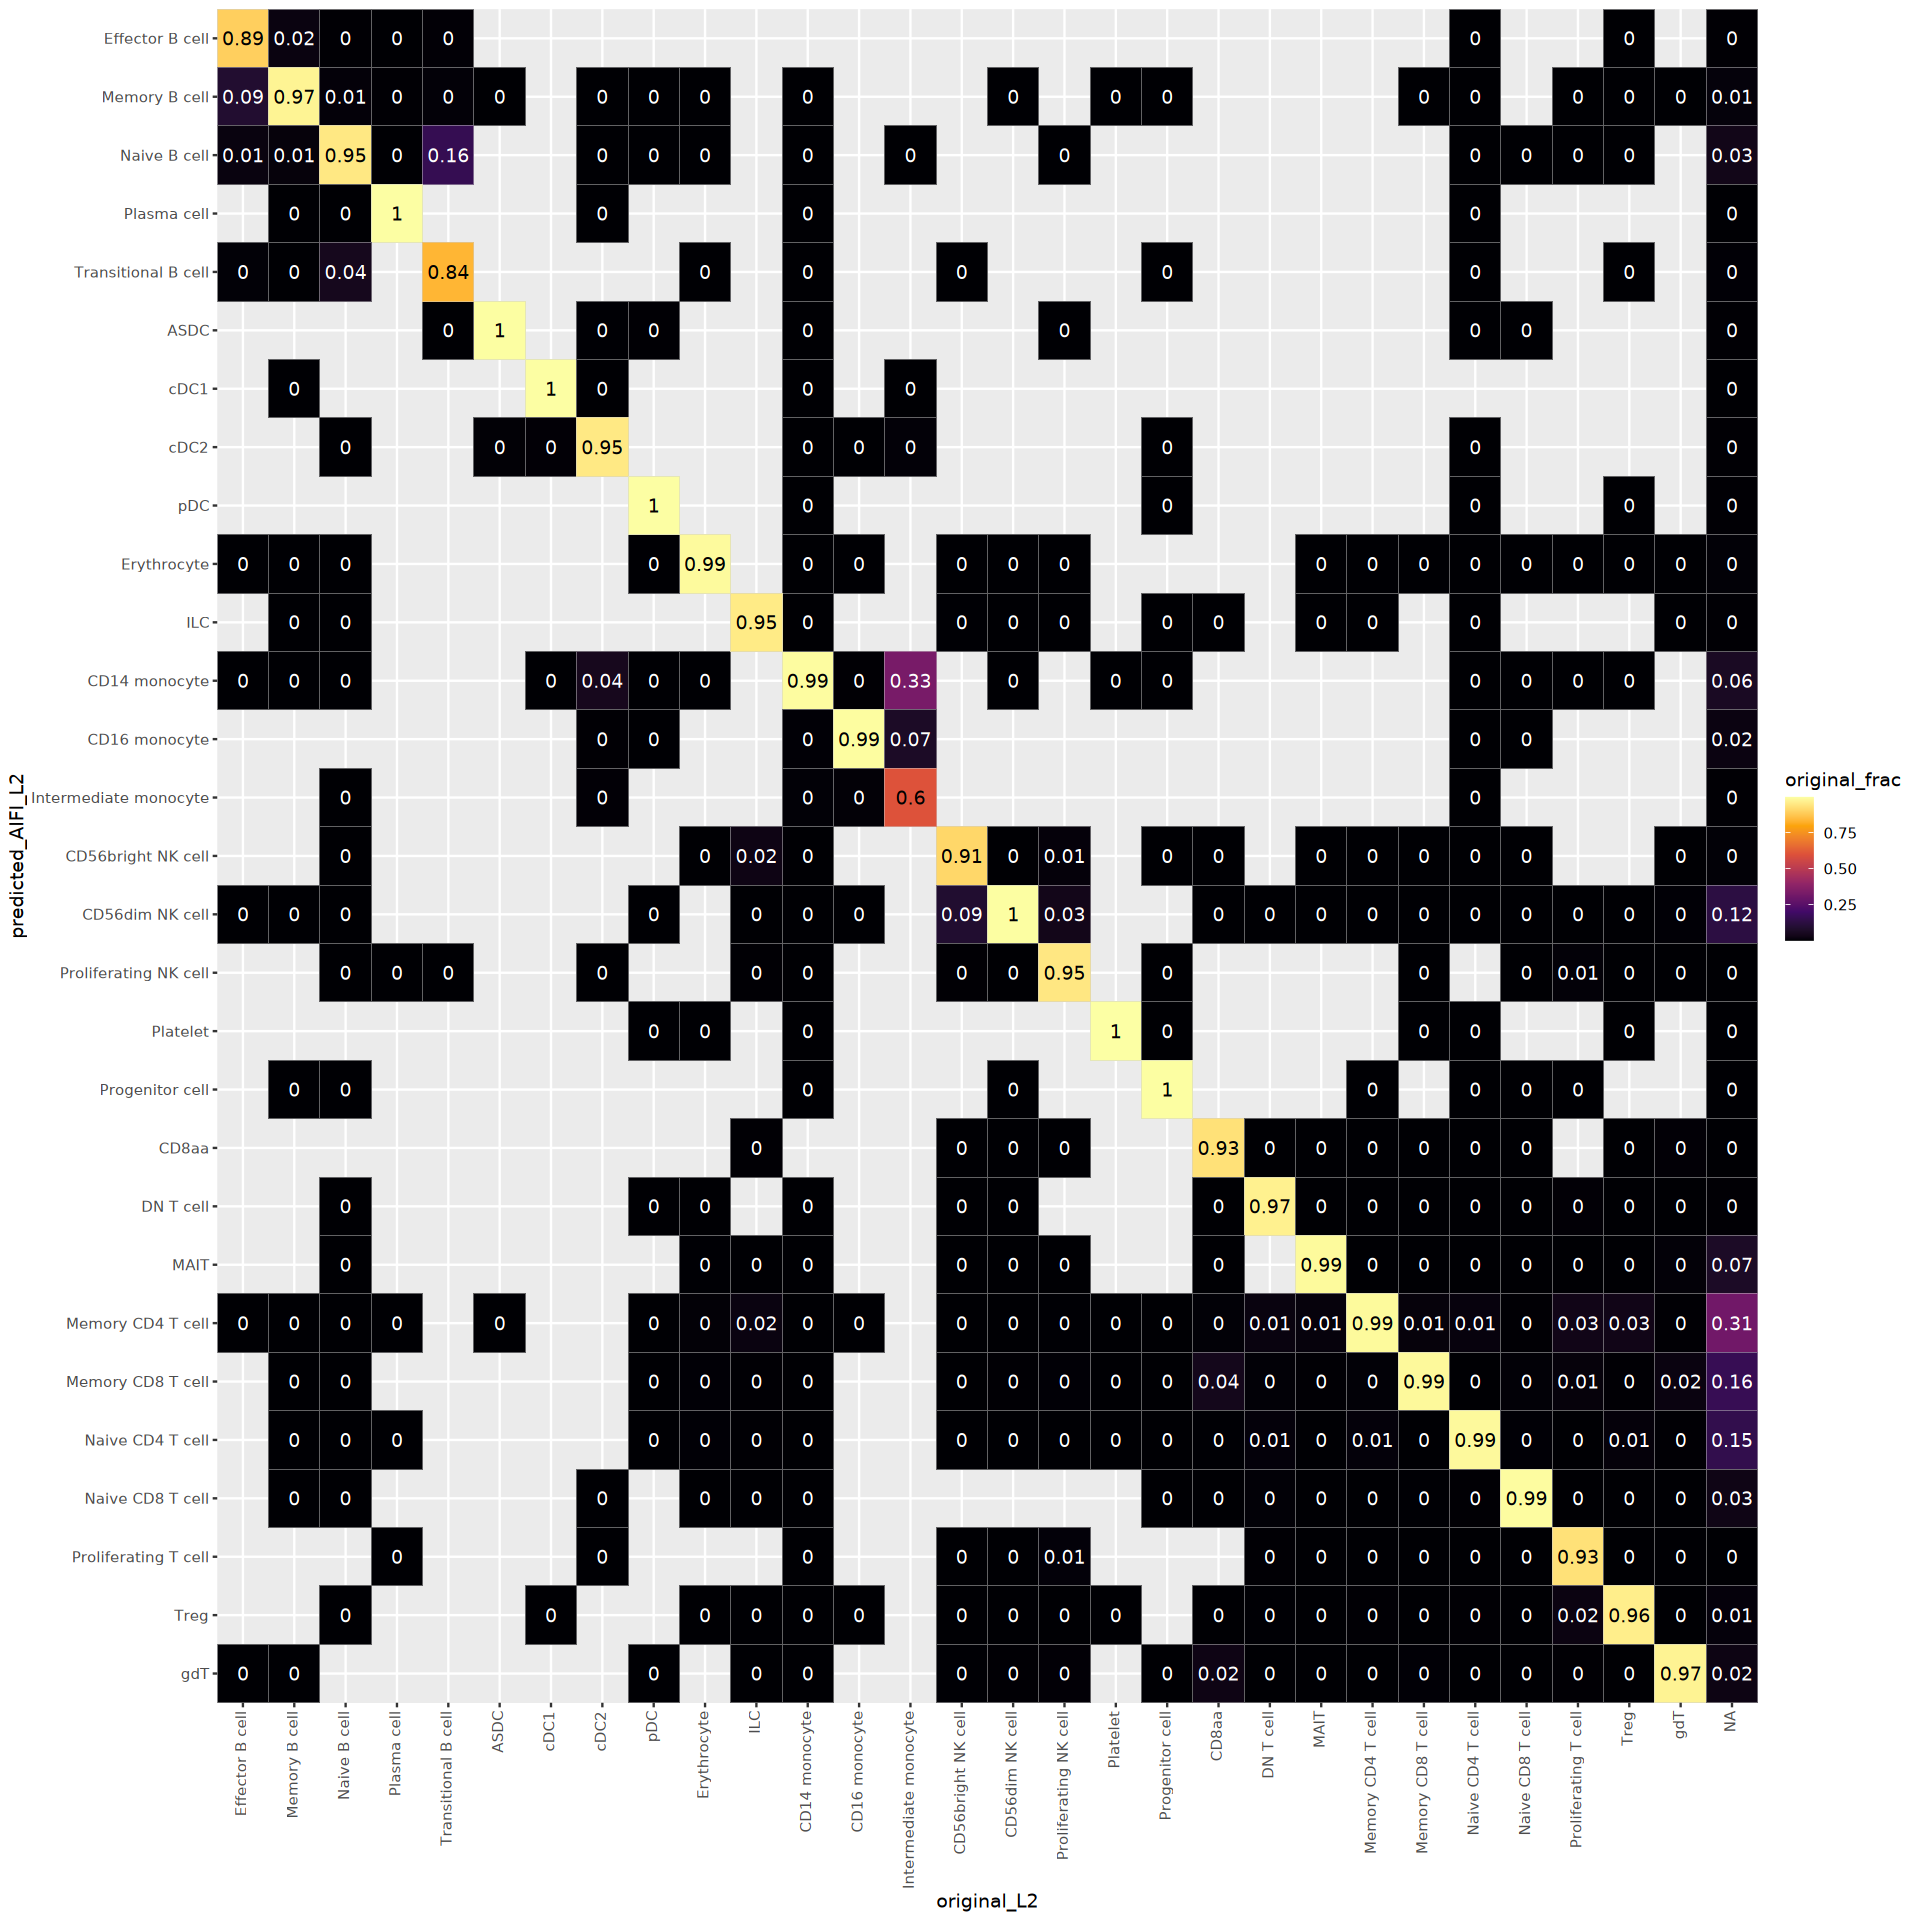

In [28]:
options(repr.plot.width = 16, repr.plot.height = 16)
ggplot() +
  geom_tile(
      data = l2_crosstab,
      aes(x = original_L2,
          y = predicted_AIFI_L2,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l2_crosstab,
      aes(x = original_L2,
          y = predicted_AIFI_L2,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L3

In [29]:
l3_crosstab <- all_meta %>%
  group_by(predicted_AIFI_L3, original_L3) %>%
  tally() %>%
  group_by(predicted_AIFI_L3) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L3) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(predicted_AIFI_L3 = factor(predicted_AIFI_L3, levels = rev(l3_levels)),
         original_L3 = factor(original_L3, levels = l3_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

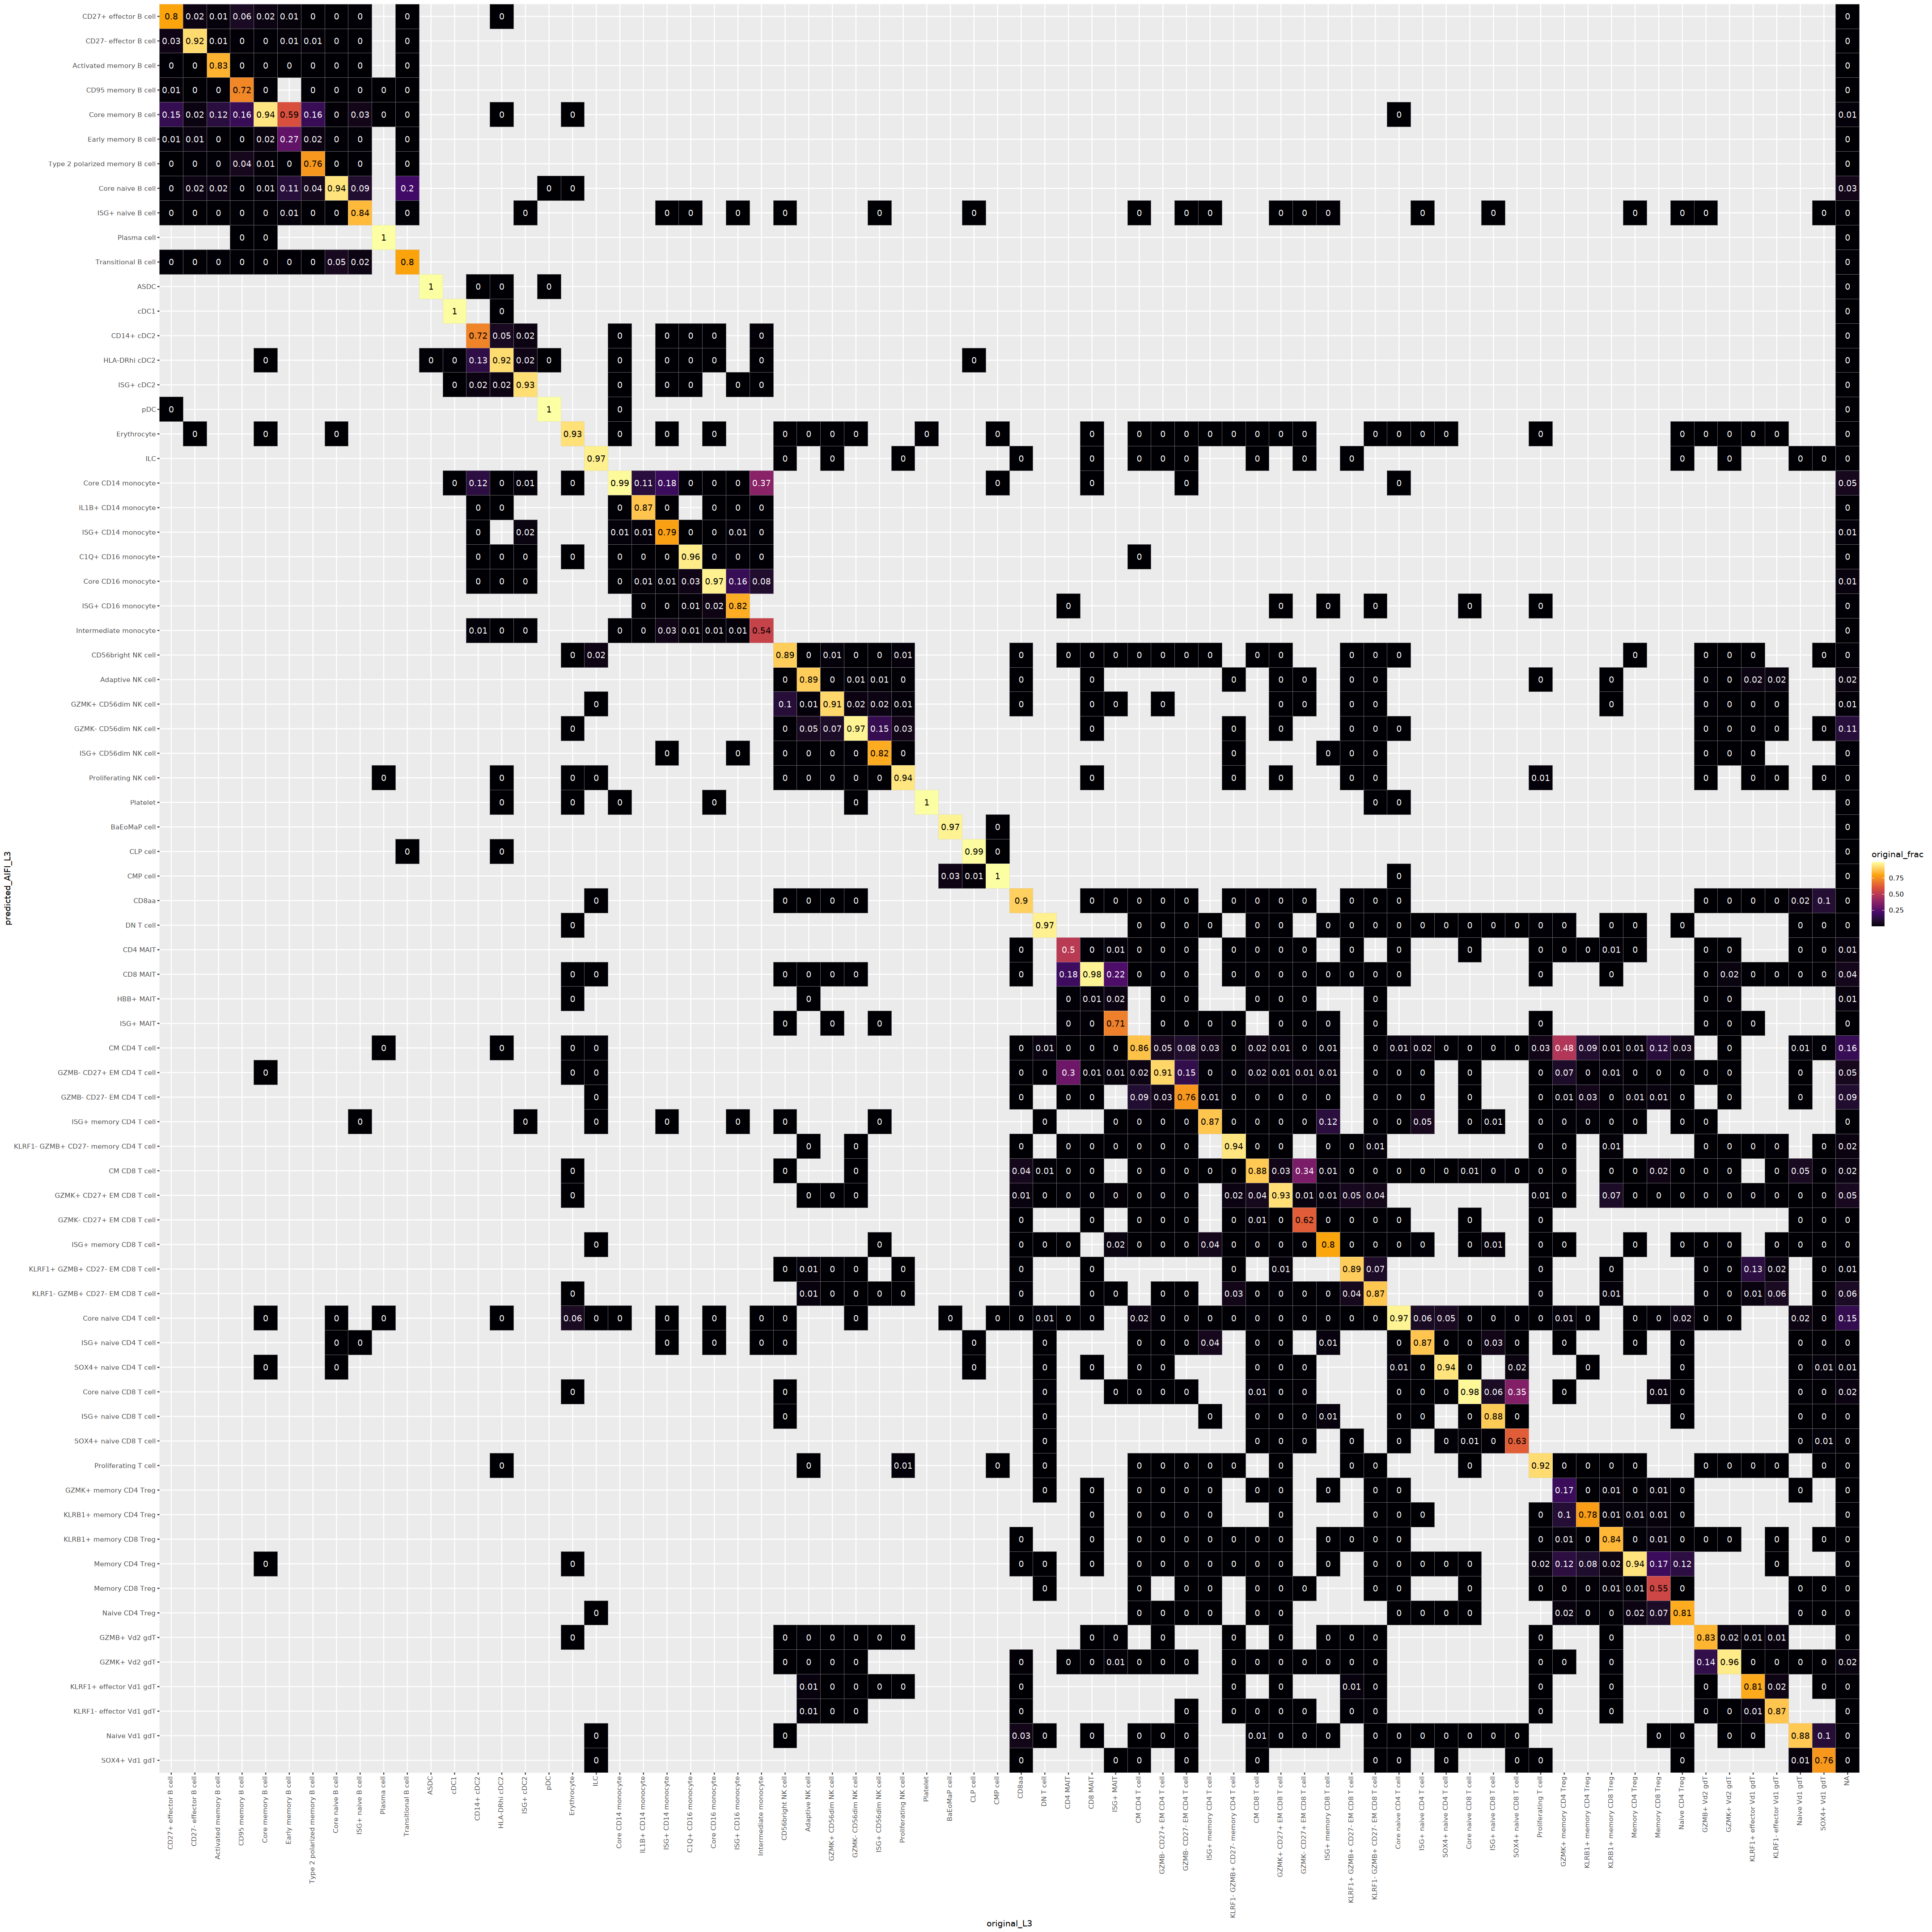

In [30]:
options(repr.plot.width = 36, repr.plot.height = 36)
ggplot() +
  geom_tile(
      data = l3_crosstab,
      aes(x = original_L3,
          y = predicted_AIFI_L3,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l3_crosstab,
      aes(x = original_L3,
          y = predicted_AIFI_L3,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

## Compare original and final labels at each level

### L1

In [31]:
l1_crosstab <- all_meta %>%
  group_by(AIFI_L1, original_L1) %>%
  tally() %>%
  group_by(AIFI_L1) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L1) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L1 = factor(AIFI_L1, levels = rev(l1_levels)),
         original_L1 = factor(original_L1, levels = l1_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

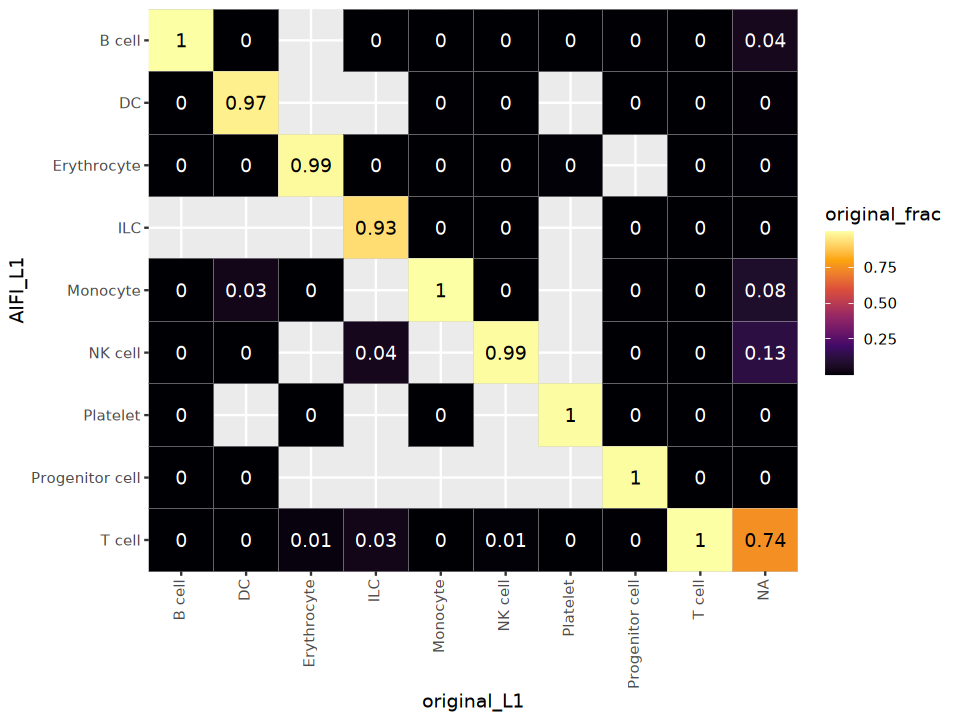

In [32]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() +
  geom_tile(
      data = l1_crosstab,
      aes(x = original_L1,
          y = AIFI_L1,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l1_crosstab,
      aes(x = original_L1,
          y = AIFI_L1,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L2

In [33]:
l2_crosstab <- all_meta %>%
  group_by(AIFI_L2, original_L2) %>%
  tally() %>%
  group_by(AIFI_L2) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L2) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L2 = factor(AIFI_L2, levels = rev(l2_levels)),
         original_L2 = factor(original_L2, levels = l2_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

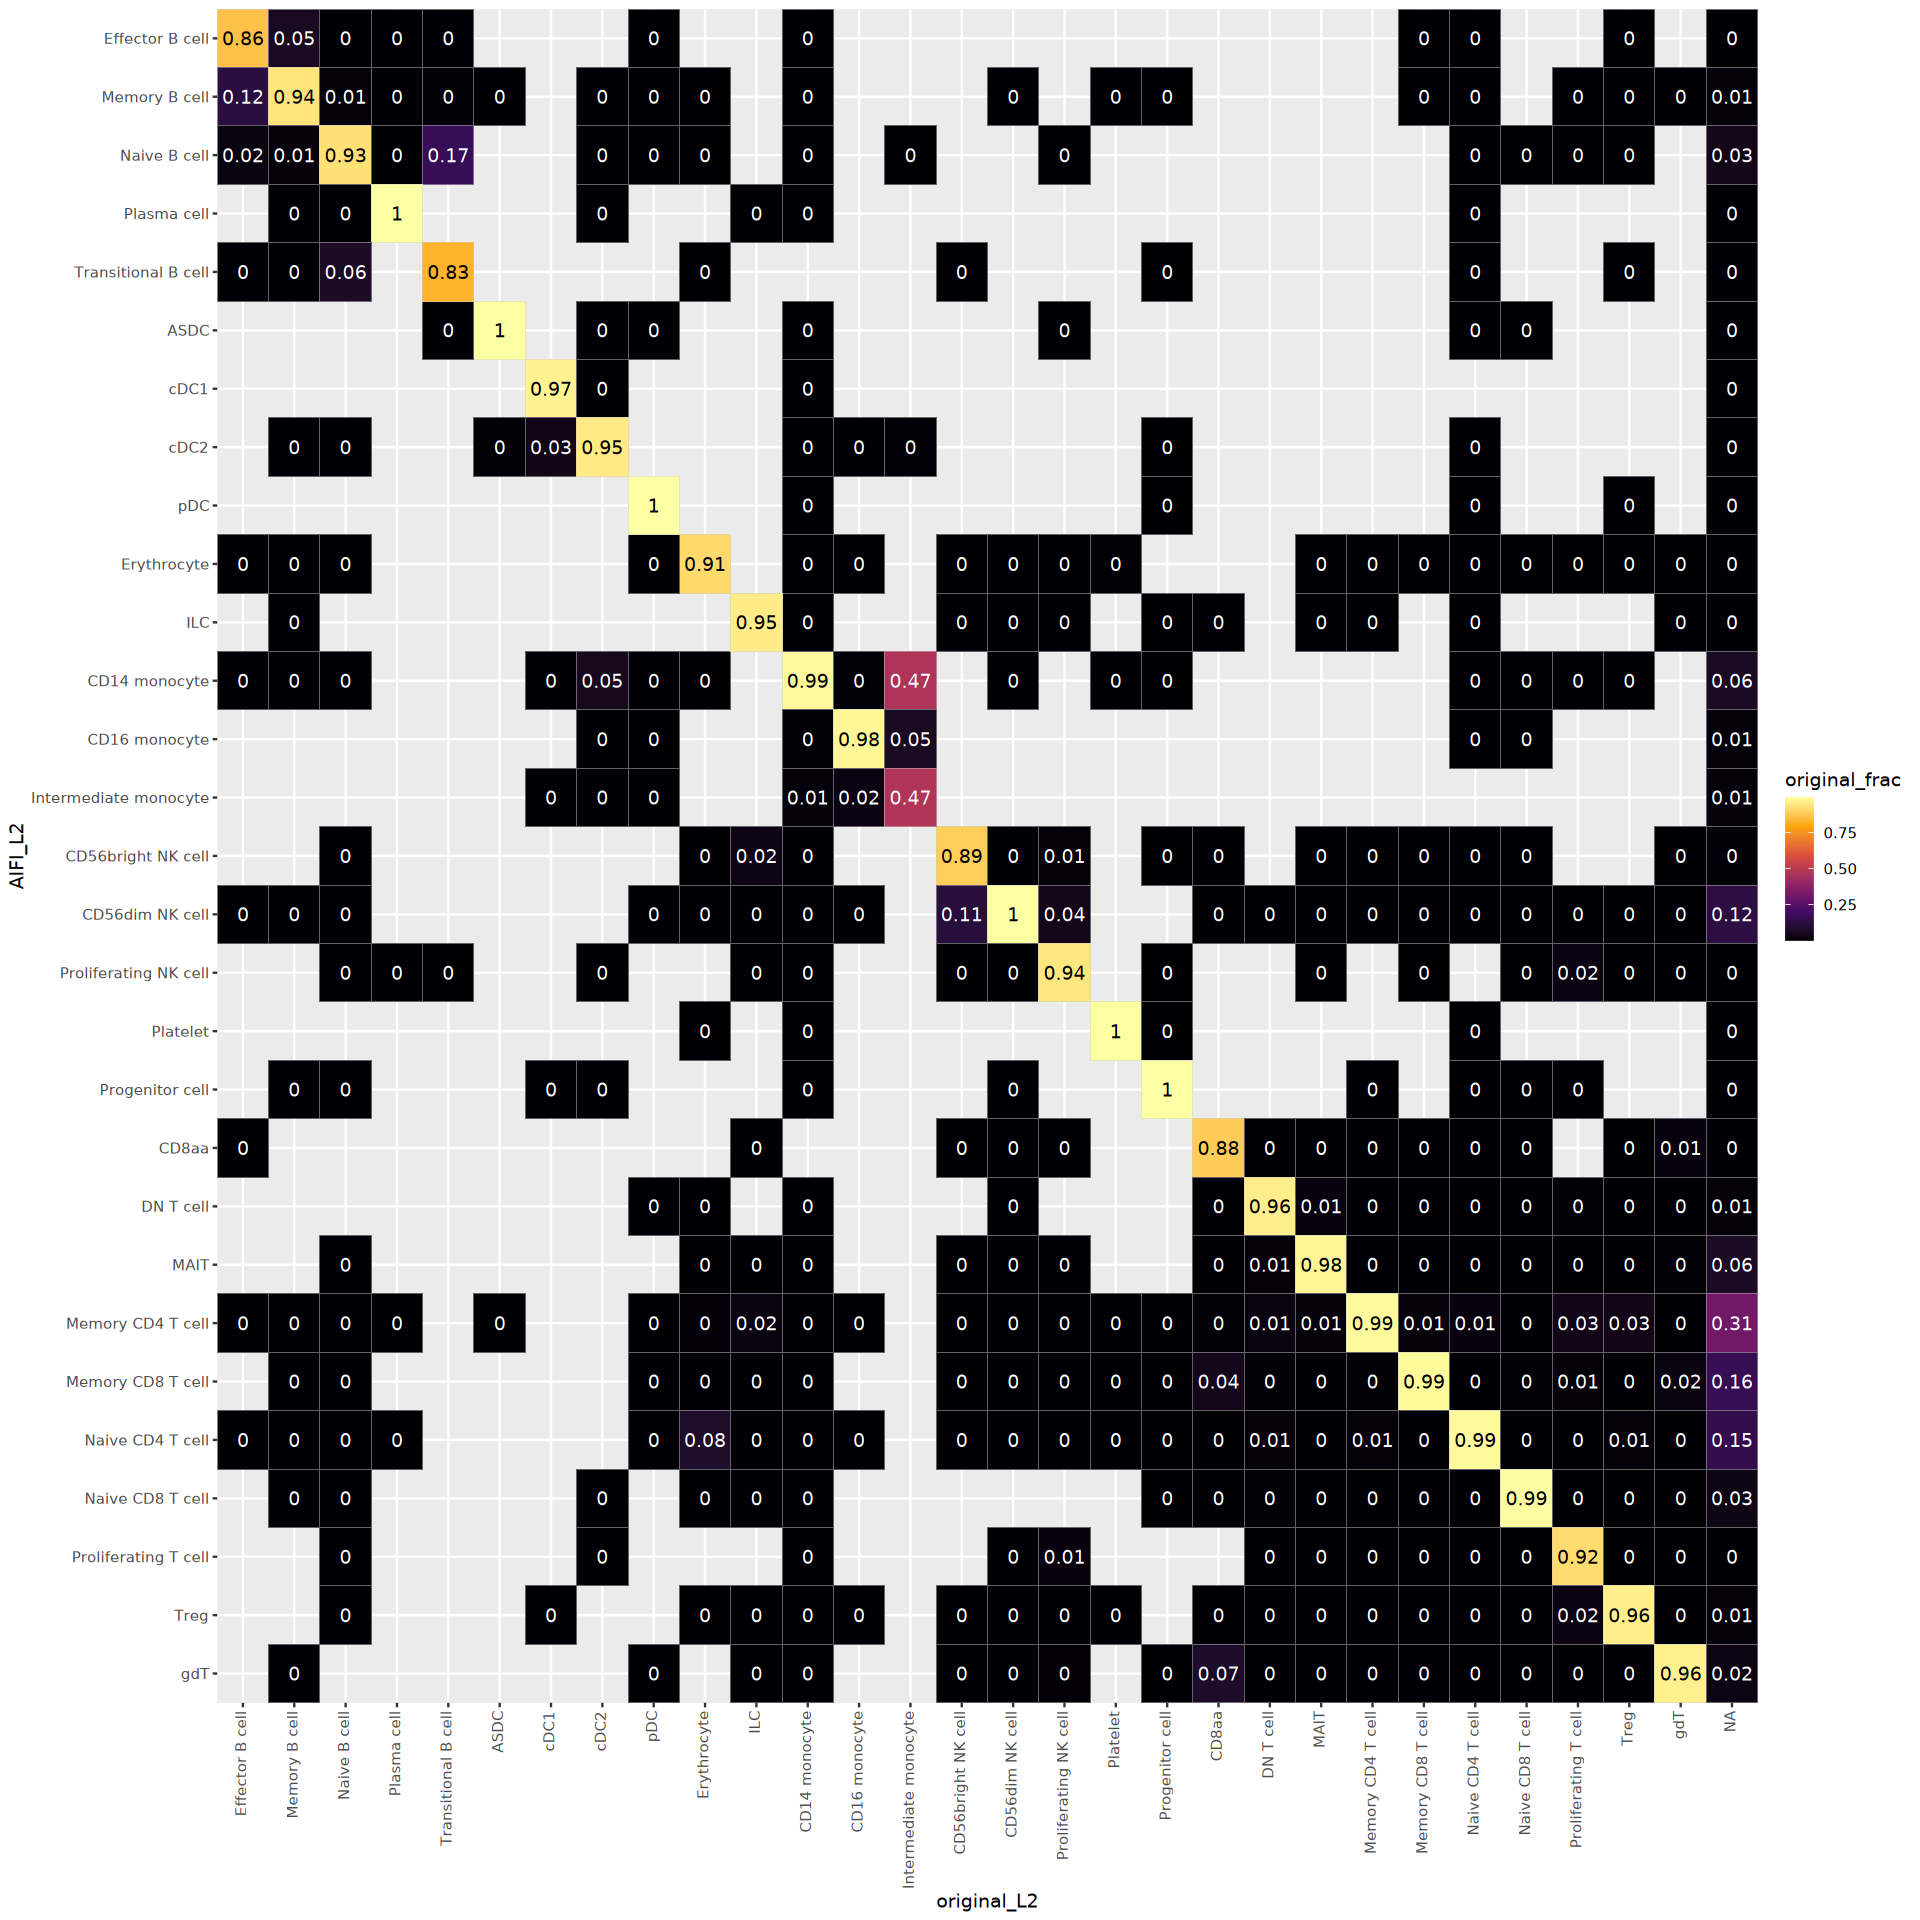

In [34]:
options(repr.plot.width = 16, repr.plot.height = 16)
ggplot() +
  geom_tile(
      data = l2_crosstab,
      aes(x = original_L2,
          y = AIFI_L2,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l2_crosstab,
      aes(x = original_L2,
          y = AIFI_L2,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L3

In [35]:
l3_crosstab <- all_meta %>%
  group_by(AIFI_L3, original_L3) %>%
  tally() %>%
  group_by(AIFI_L3) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(original_L3) %>%
  mutate(original_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L3 = factor(AIFI_L3, levels = rev(l3_levels)),
         original_L3 = factor(original_L3, levels = l3_levels)) %>%
  mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))

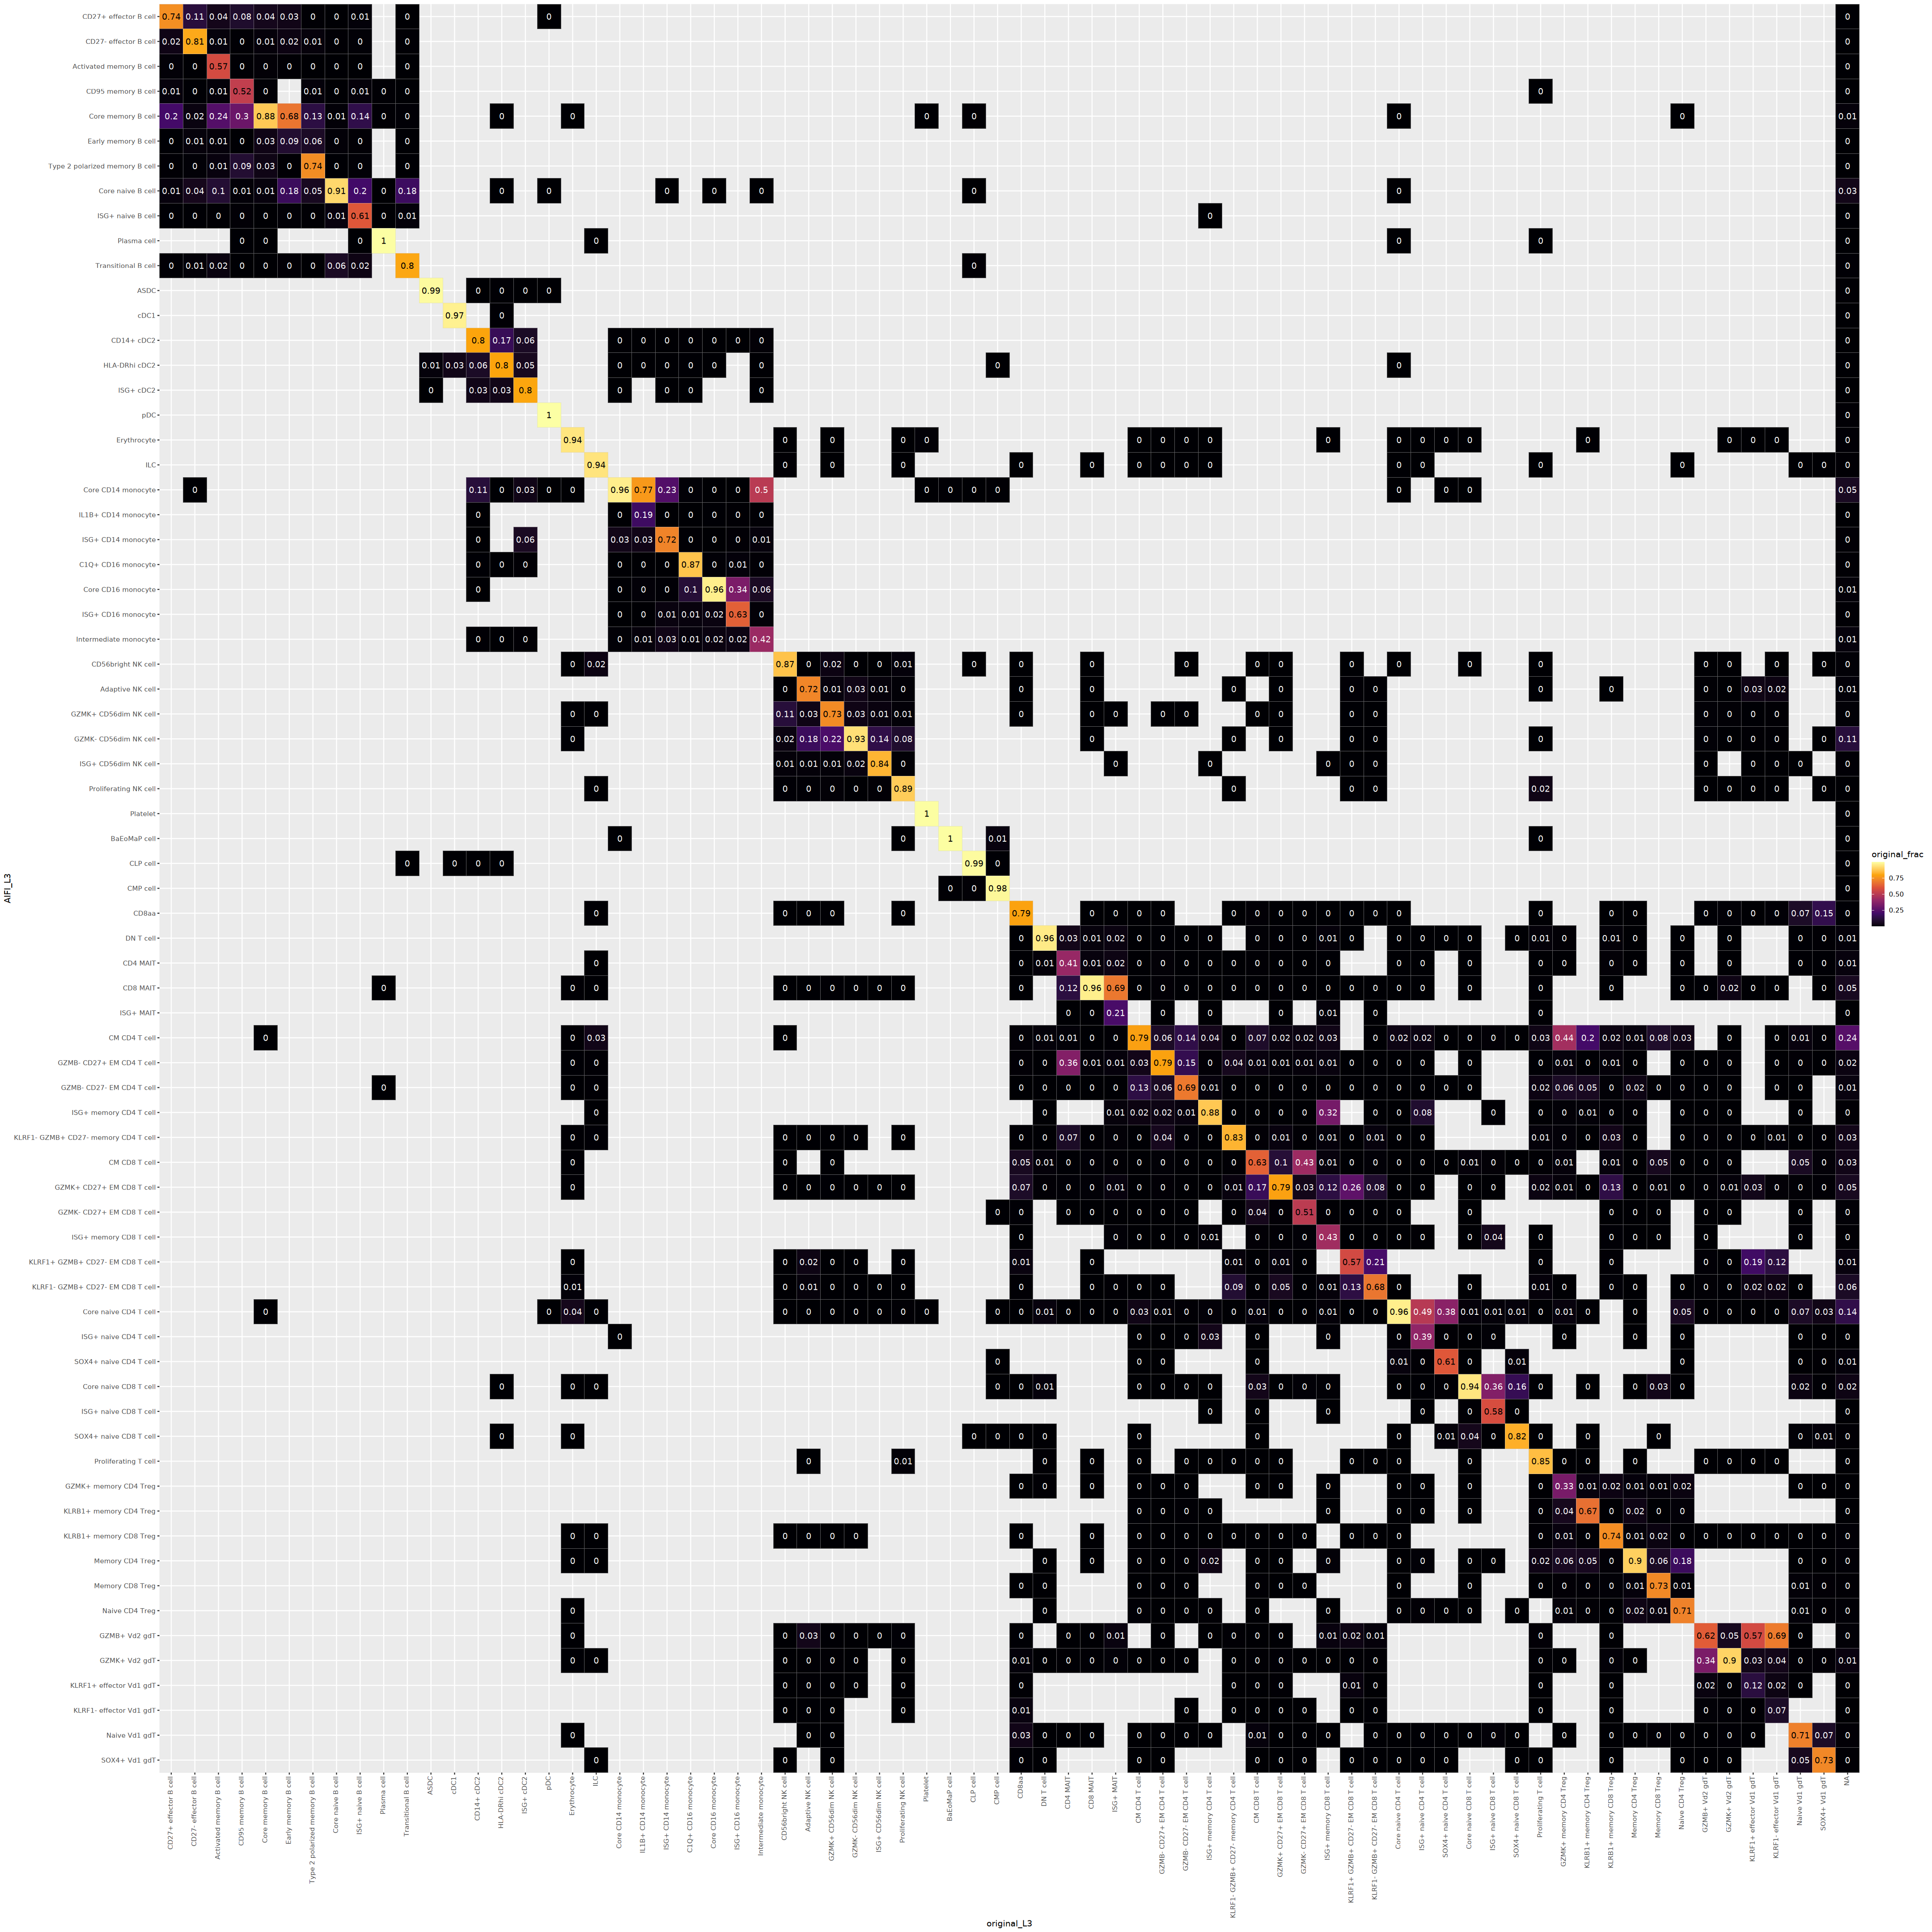

In [36]:
options(repr.plot.width = 36, repr.plot.height = 36)
ggplot() +
  geom_tile(
      data = l3_crosstab,
      aes(x = original_L3,
          y = AIFI_L3,
          fill = original_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l3_crosstab,
      aes(x = original_L3,
          y = AIFI_L3,
          label = round(original_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L3 labels within each L1 class

In [37]:
l1_meta <- split(all_meta, all_meta$AIFI_L1)

In [38]:
l1_crosstabs_l3 <- map(
    l1_meta,
    function(meta) {
        l3_targets = unique(meta$AIFI_L3)
        
        l3_crosstab <- meta %>%
          mutate(original_L3 = ifelse(original_L3 %in% l3_targets, original_L3, "Other")) %>%
          group_by(AIFI_L3, original_L3) %>%
          tally() %>%
          group_by(AIFI_L3) %>%
          mutate(AIFI_frac = n / sum(n)) %>%
          group_by(original_L3) %>%
          mutate(original_frac = n / sum(n)) %>%
          ungroup() %>%
          mutate(AIFI_L3 = factor(AIFI_L3, levels = rev(l3_levels)),
                 original_L3 = factor(original_L3, levels = l3_levels)) %>%
          mutate(text_color = ifelse(original_frac < 0.5, "white", "black"))
    }
)

In [39]:
l1_plots_l3 <- map(
    l1_crosstabs_l3,
    function(l3_crosstab) {
        ggplot() +
          geom_tile(
              data = l3_crosstab,
              aes(x = original_L3,
                  y = AIFI_L3,
                  fill = original_frac),
              color = "gray80"
          ) +
          geom_text(
              data = l3_crosstab,
              aes(x = original_L3,
                  y = AIFI_L3,
                  label = round(original_frac,2),
                  color = text_color
                  )
          ) +
          scale_x_discrete(expand = c(0,0)) +
          scale_y_discrete(expand = c(0,0)) +
          scale_fill_viridis_c(option = "B") +
          scale_color_identity() +
          theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))
    }
)

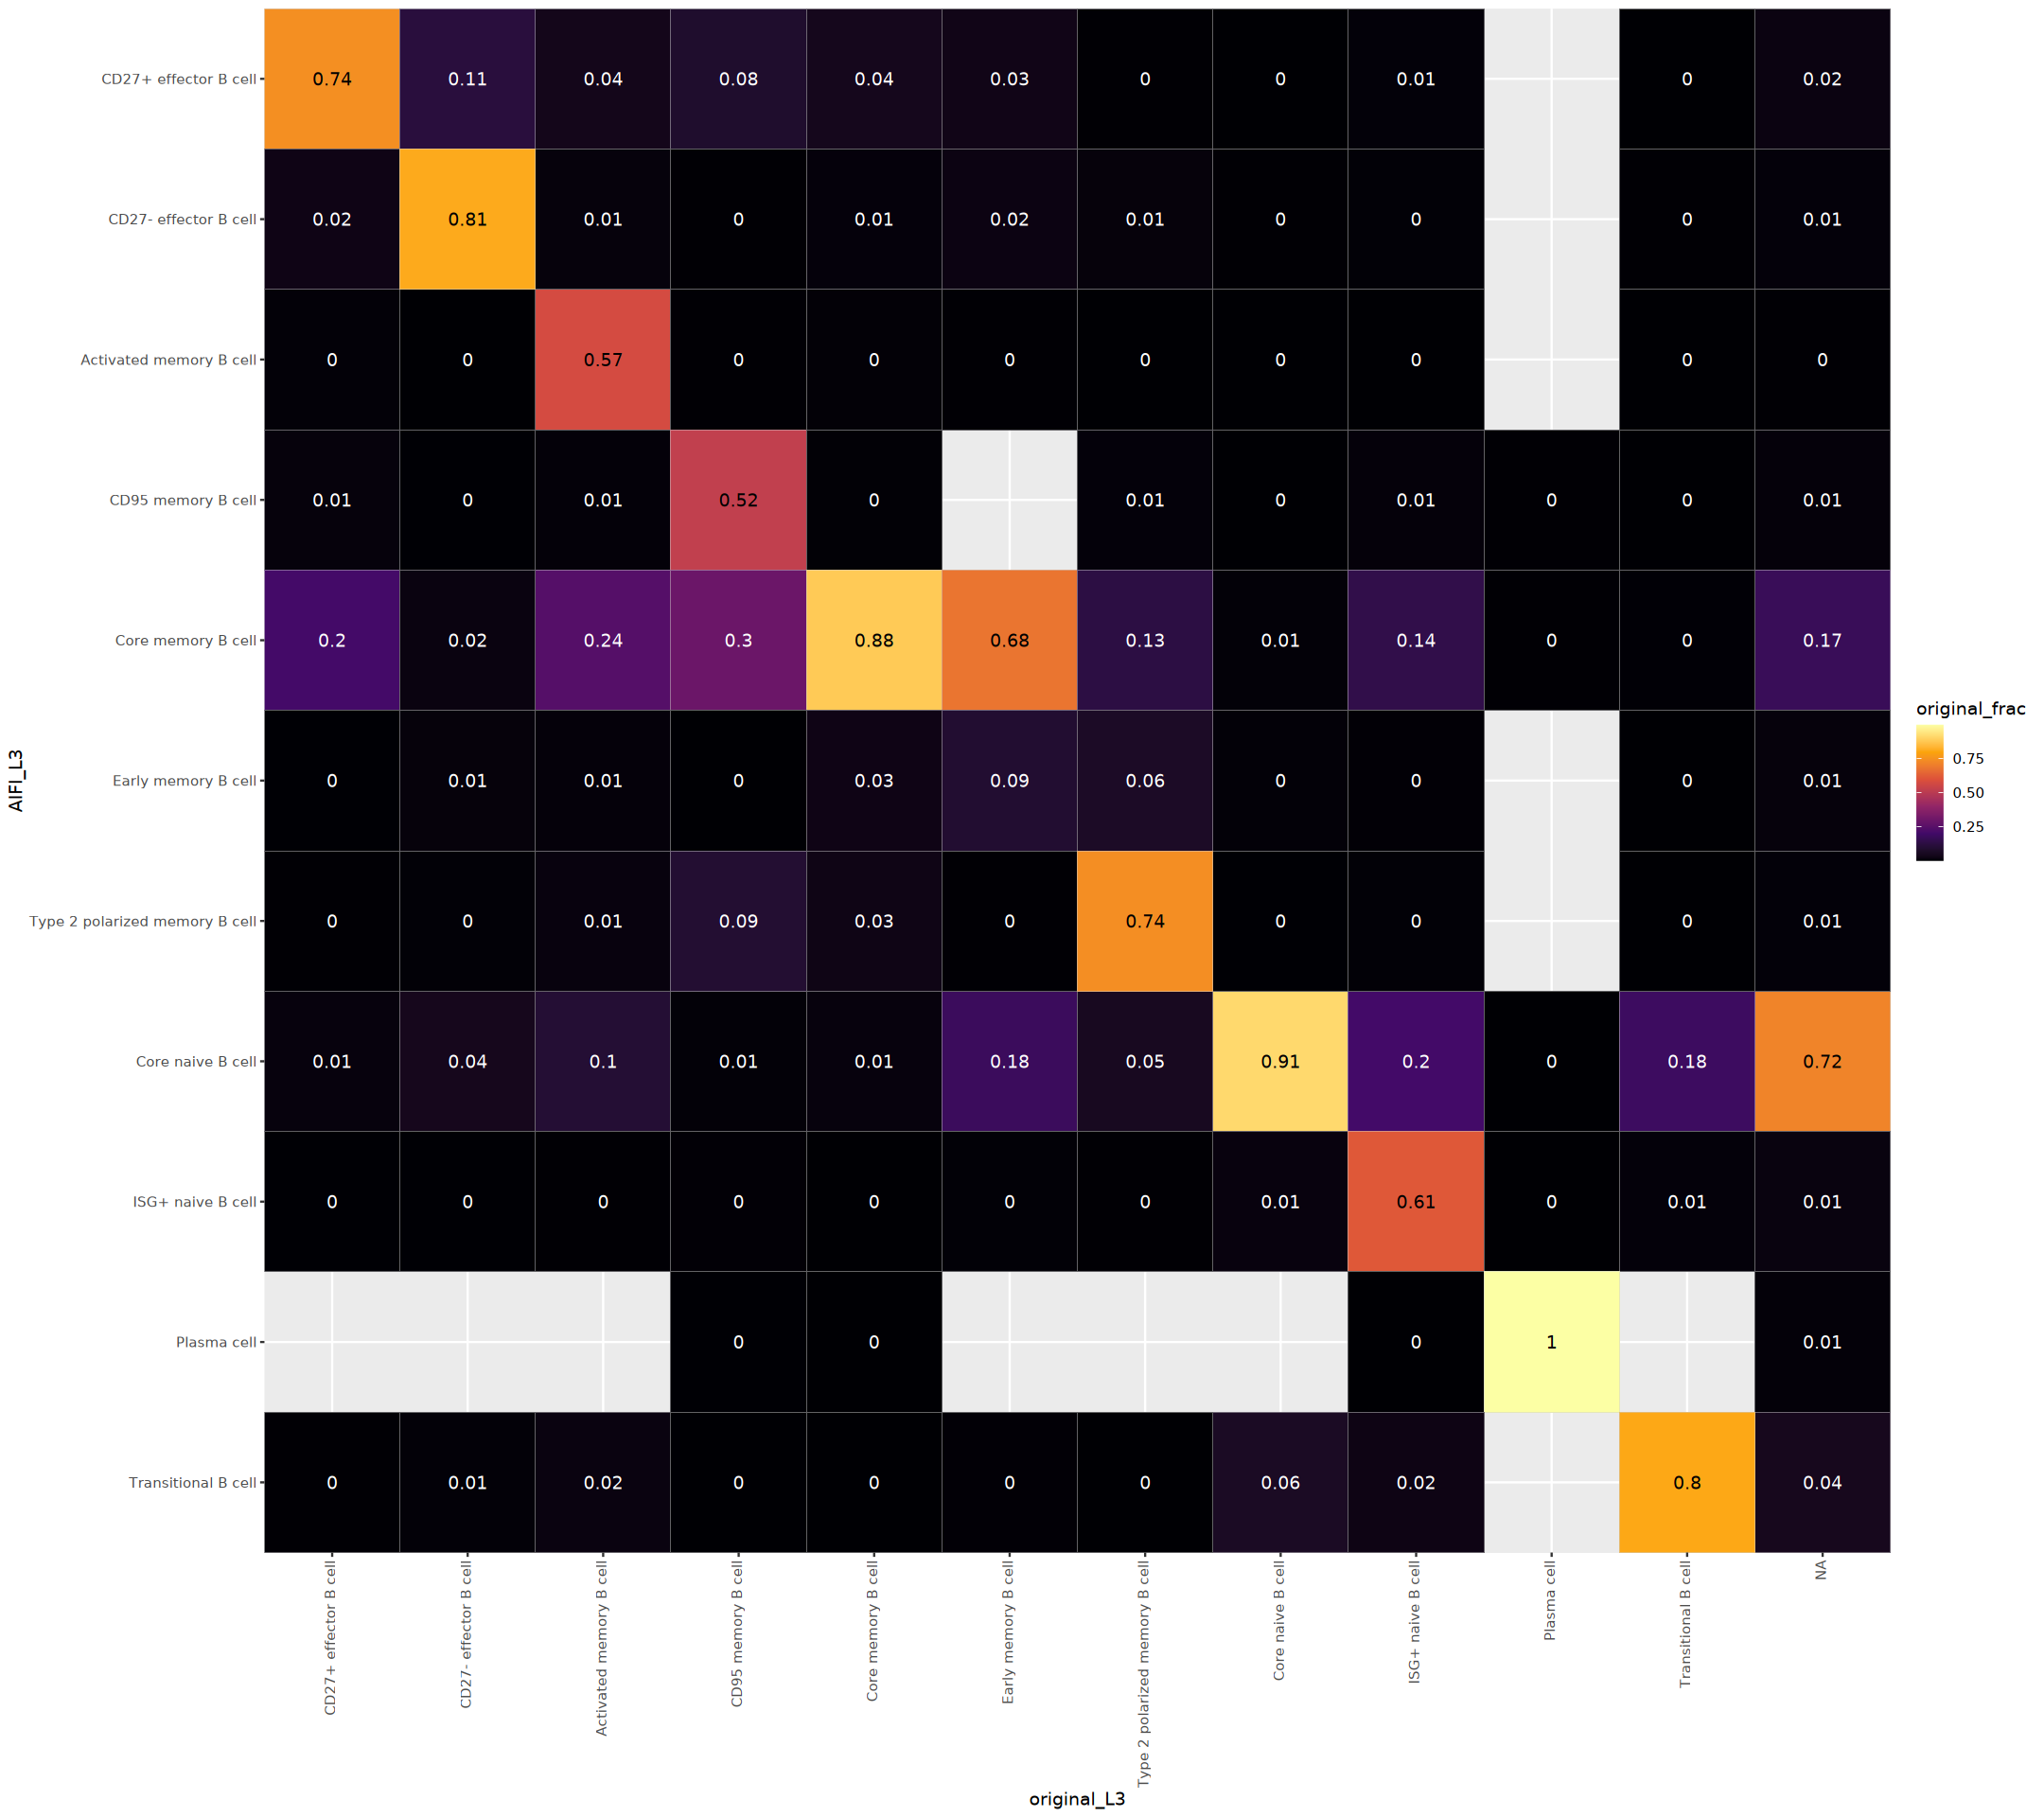

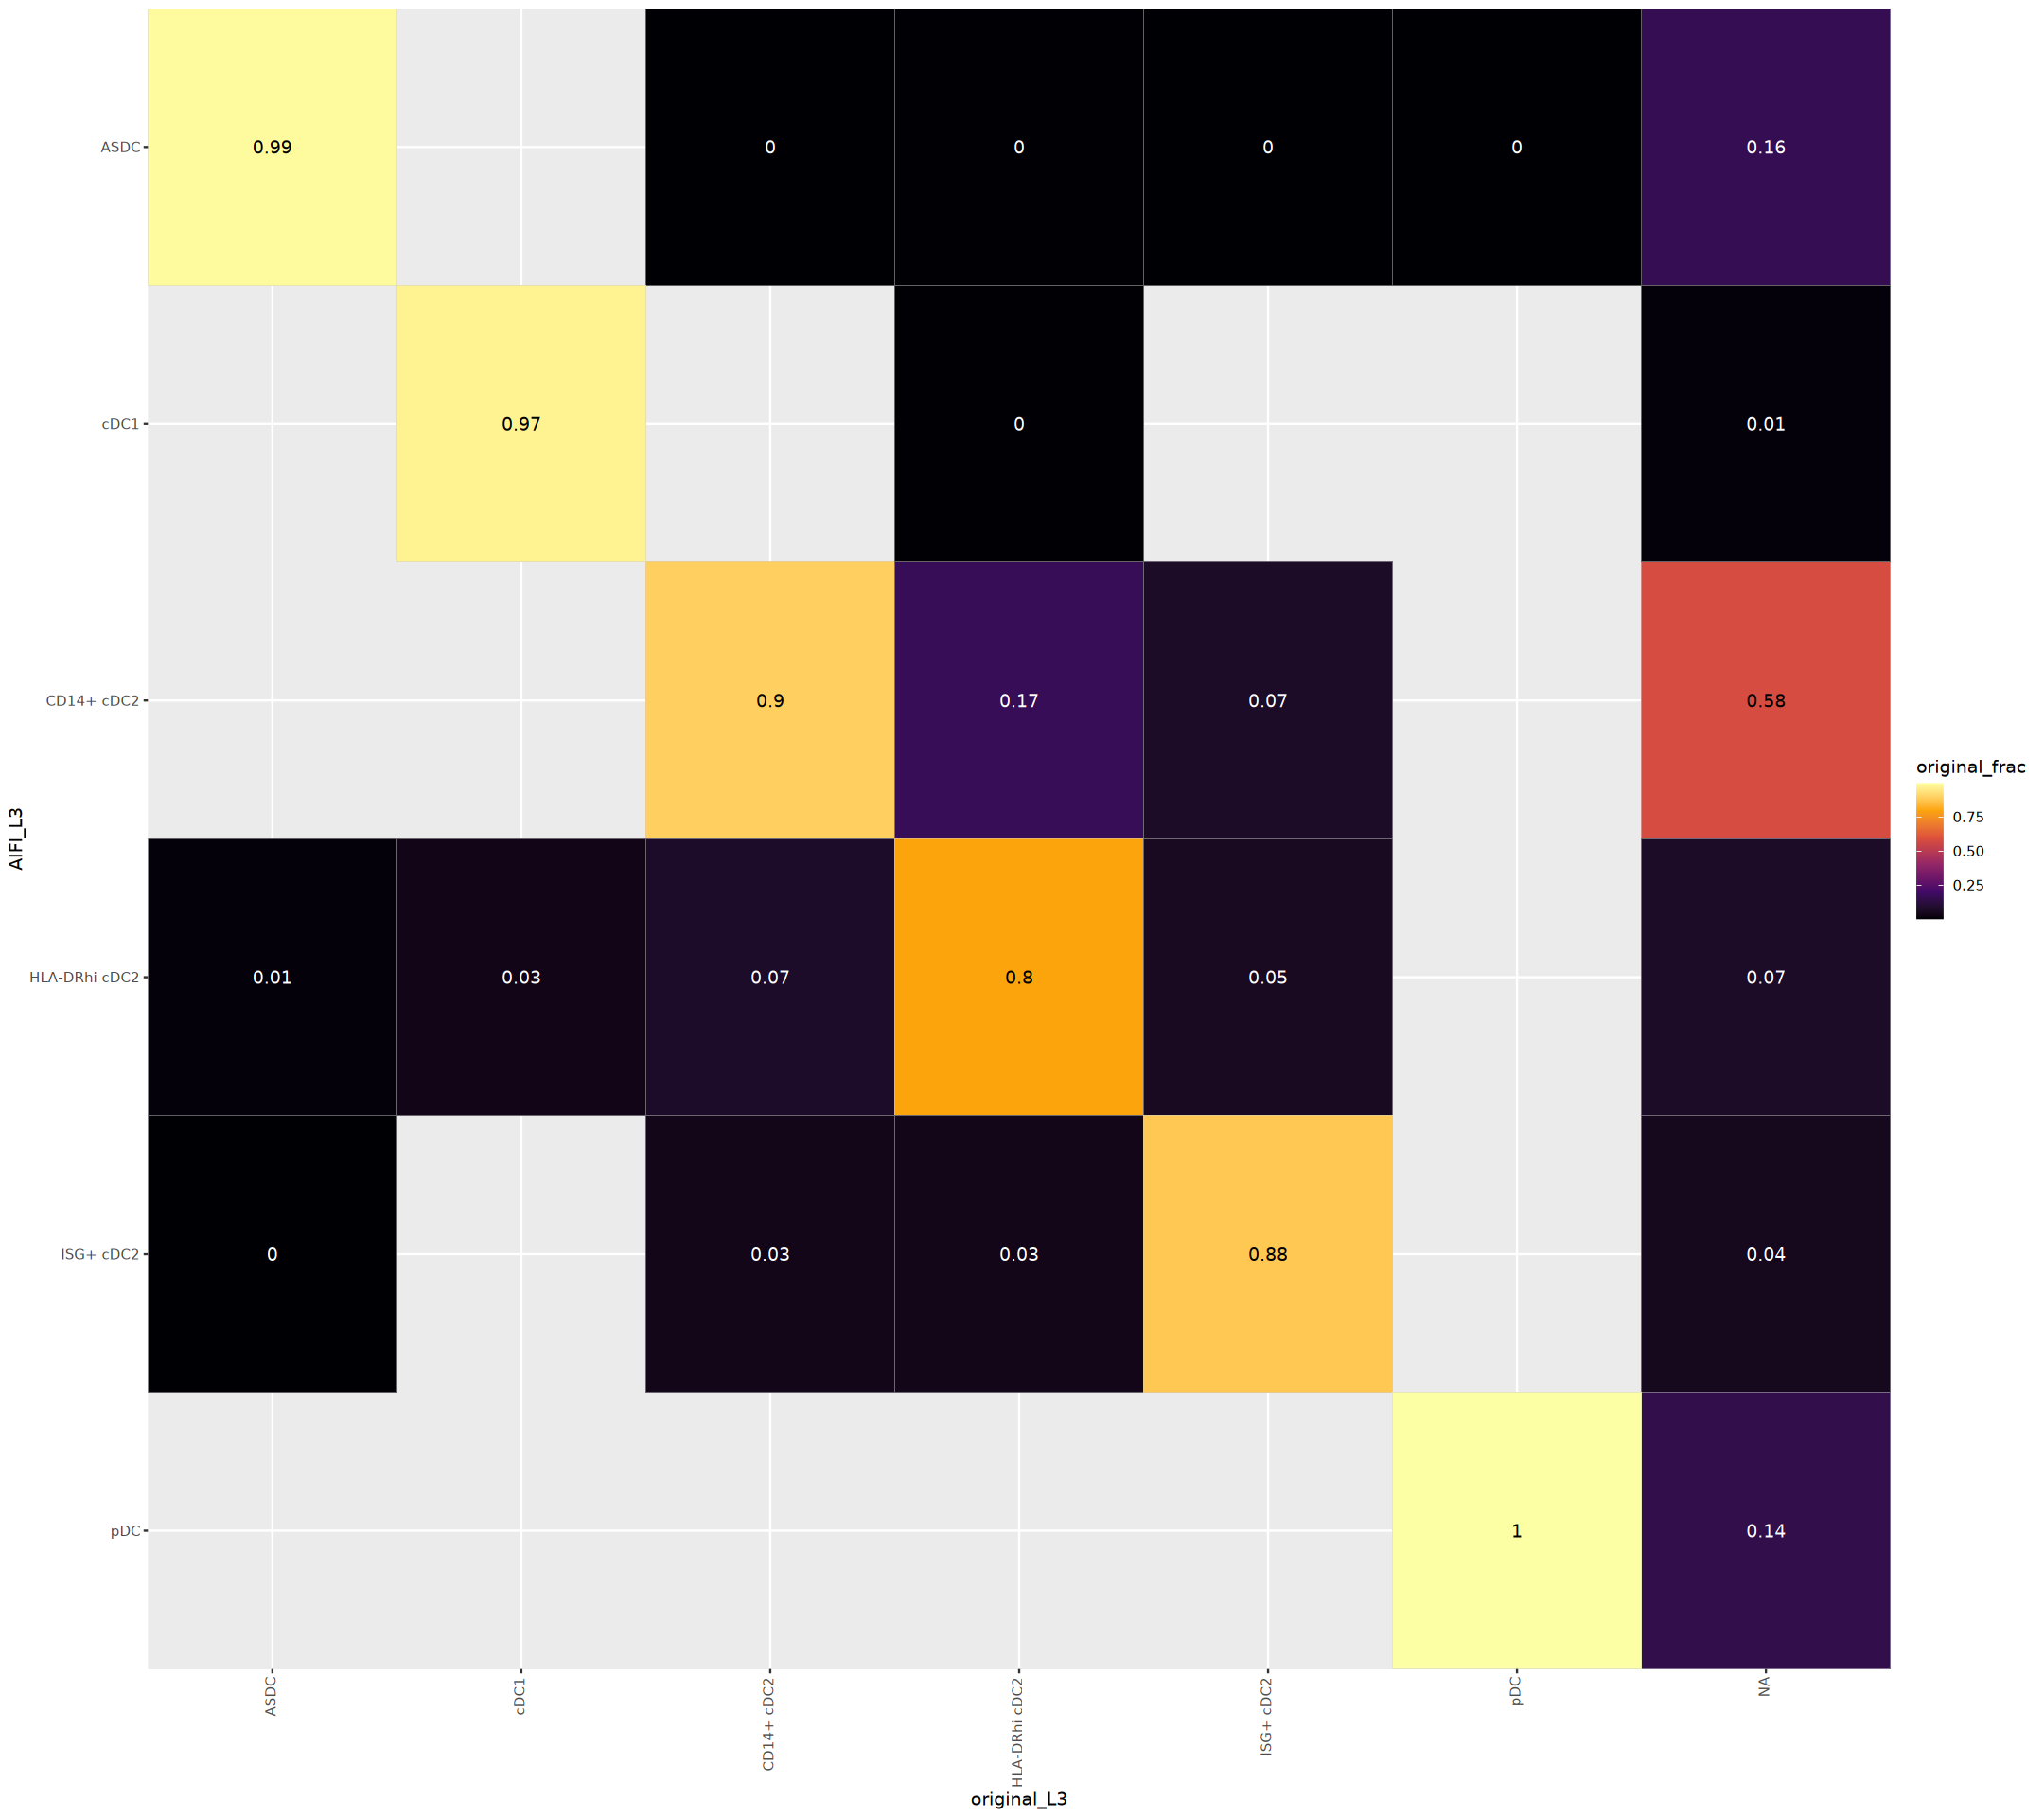

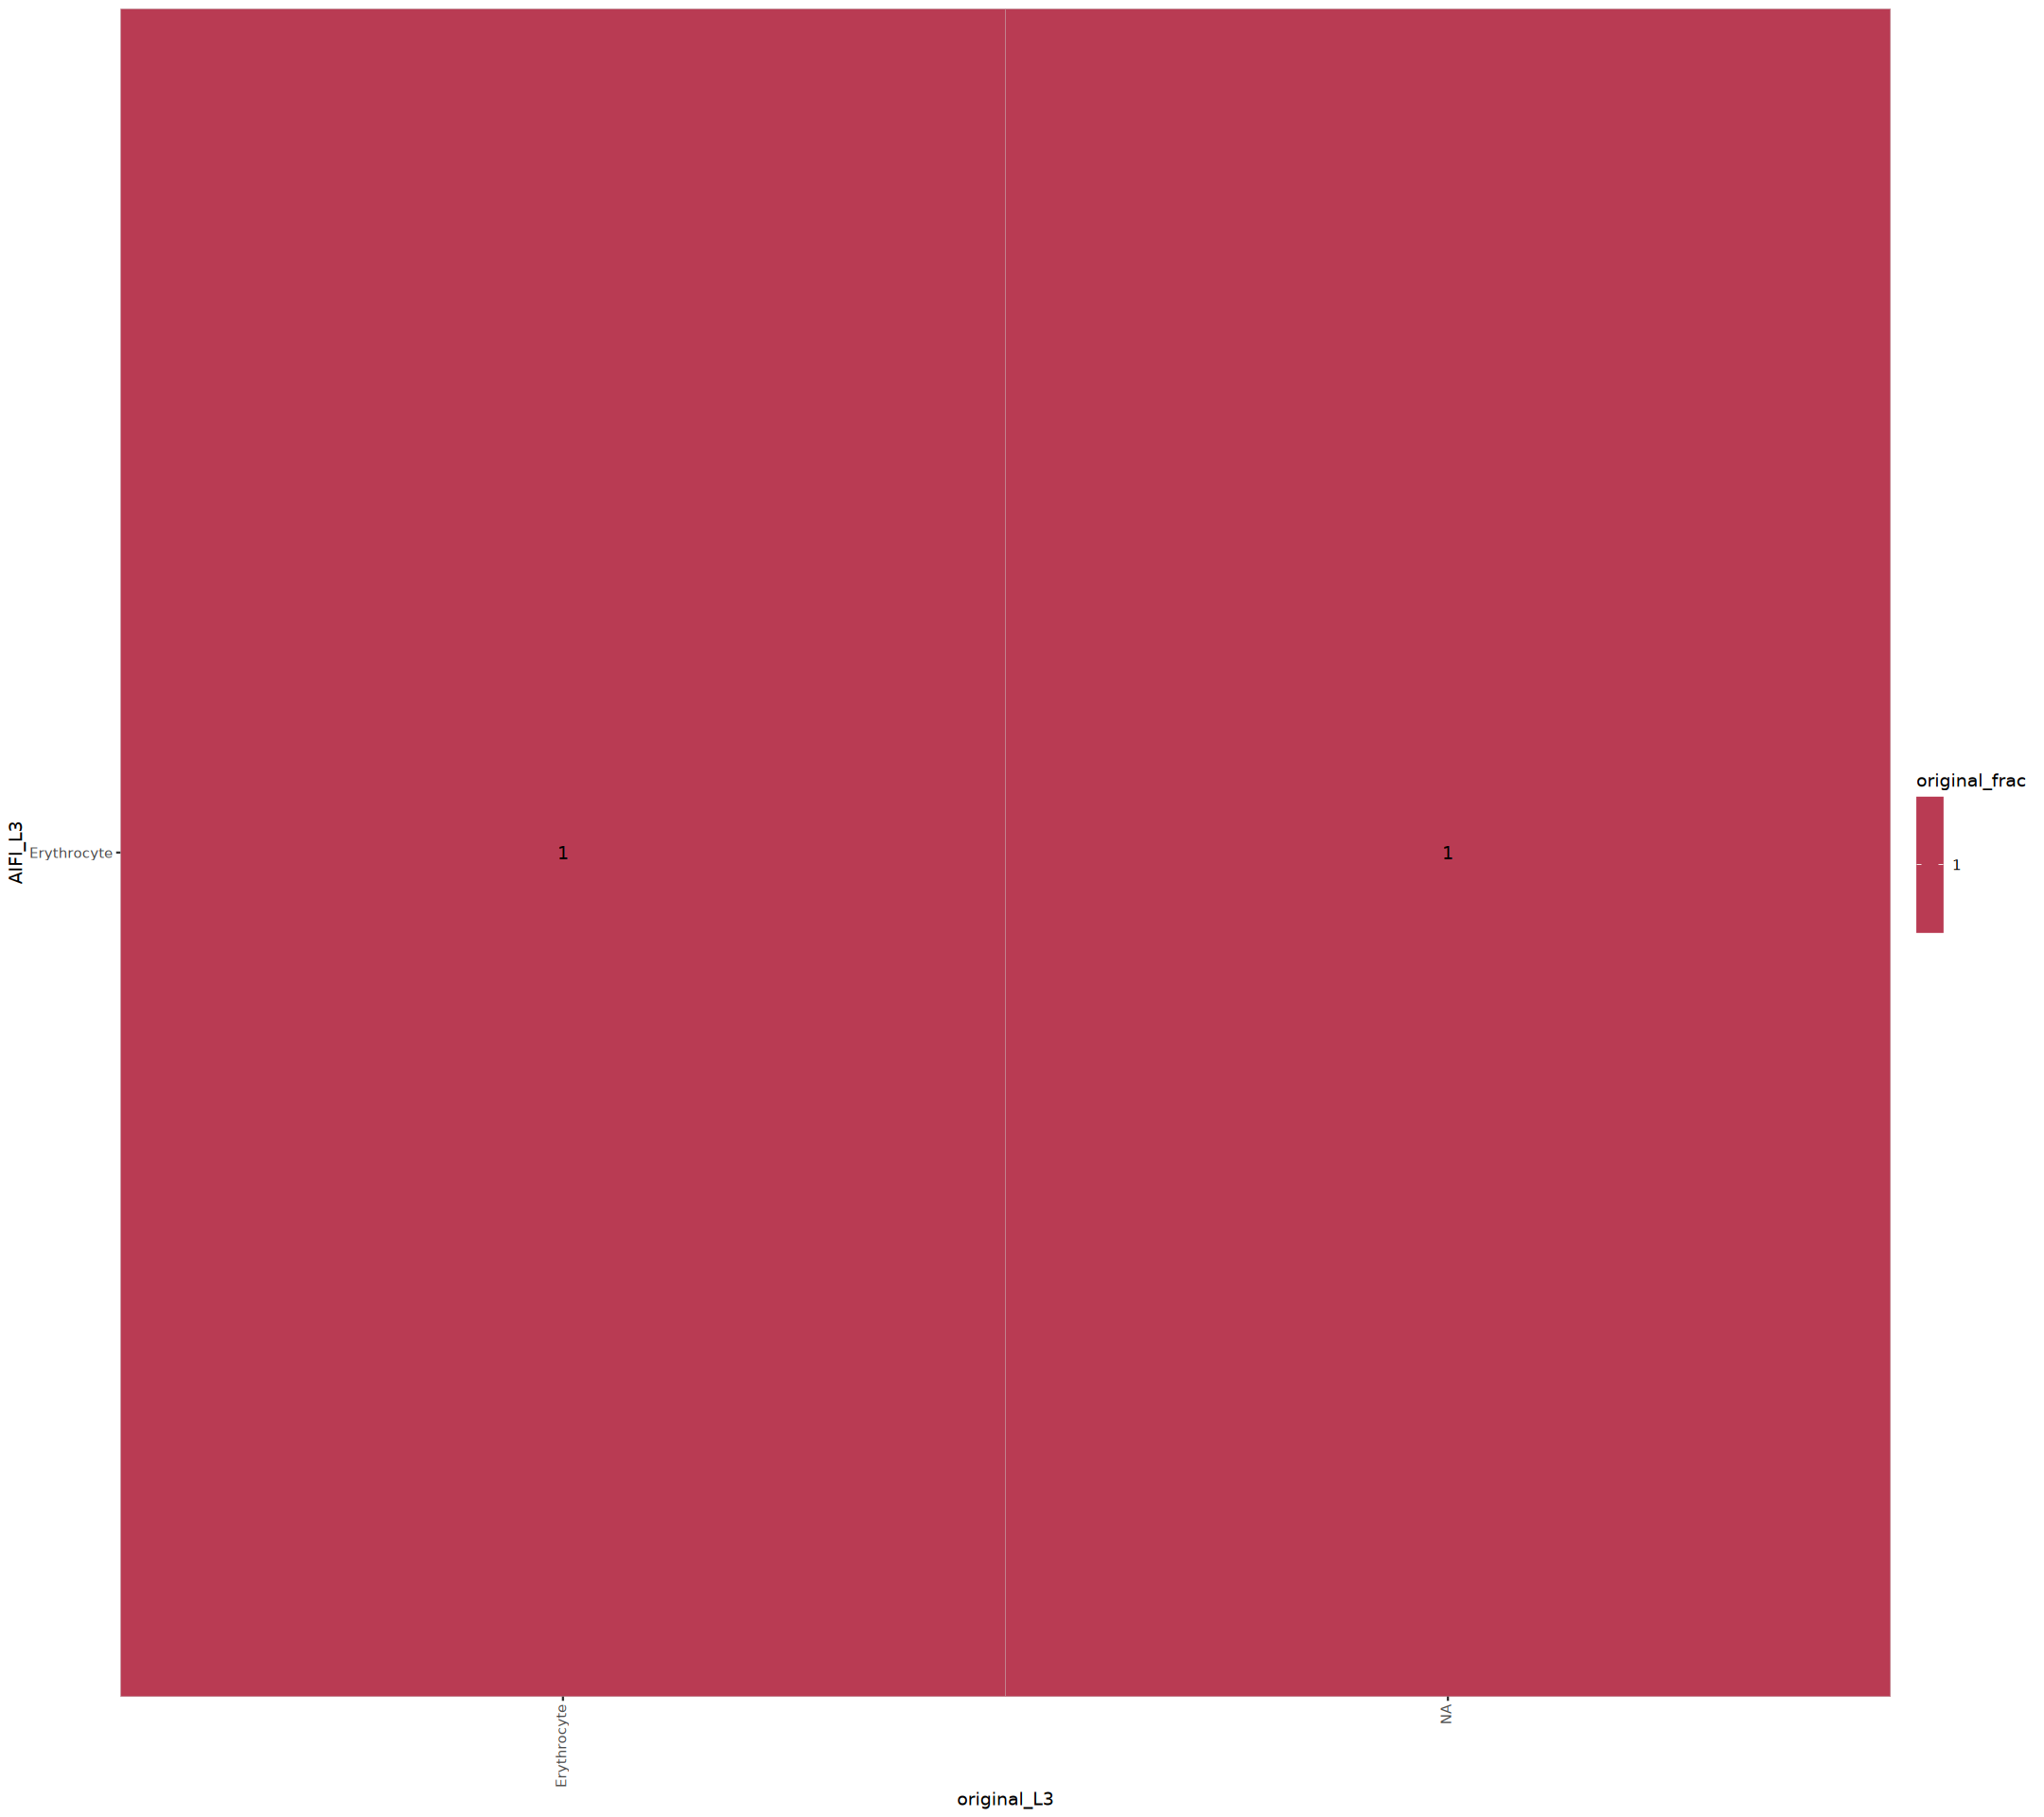

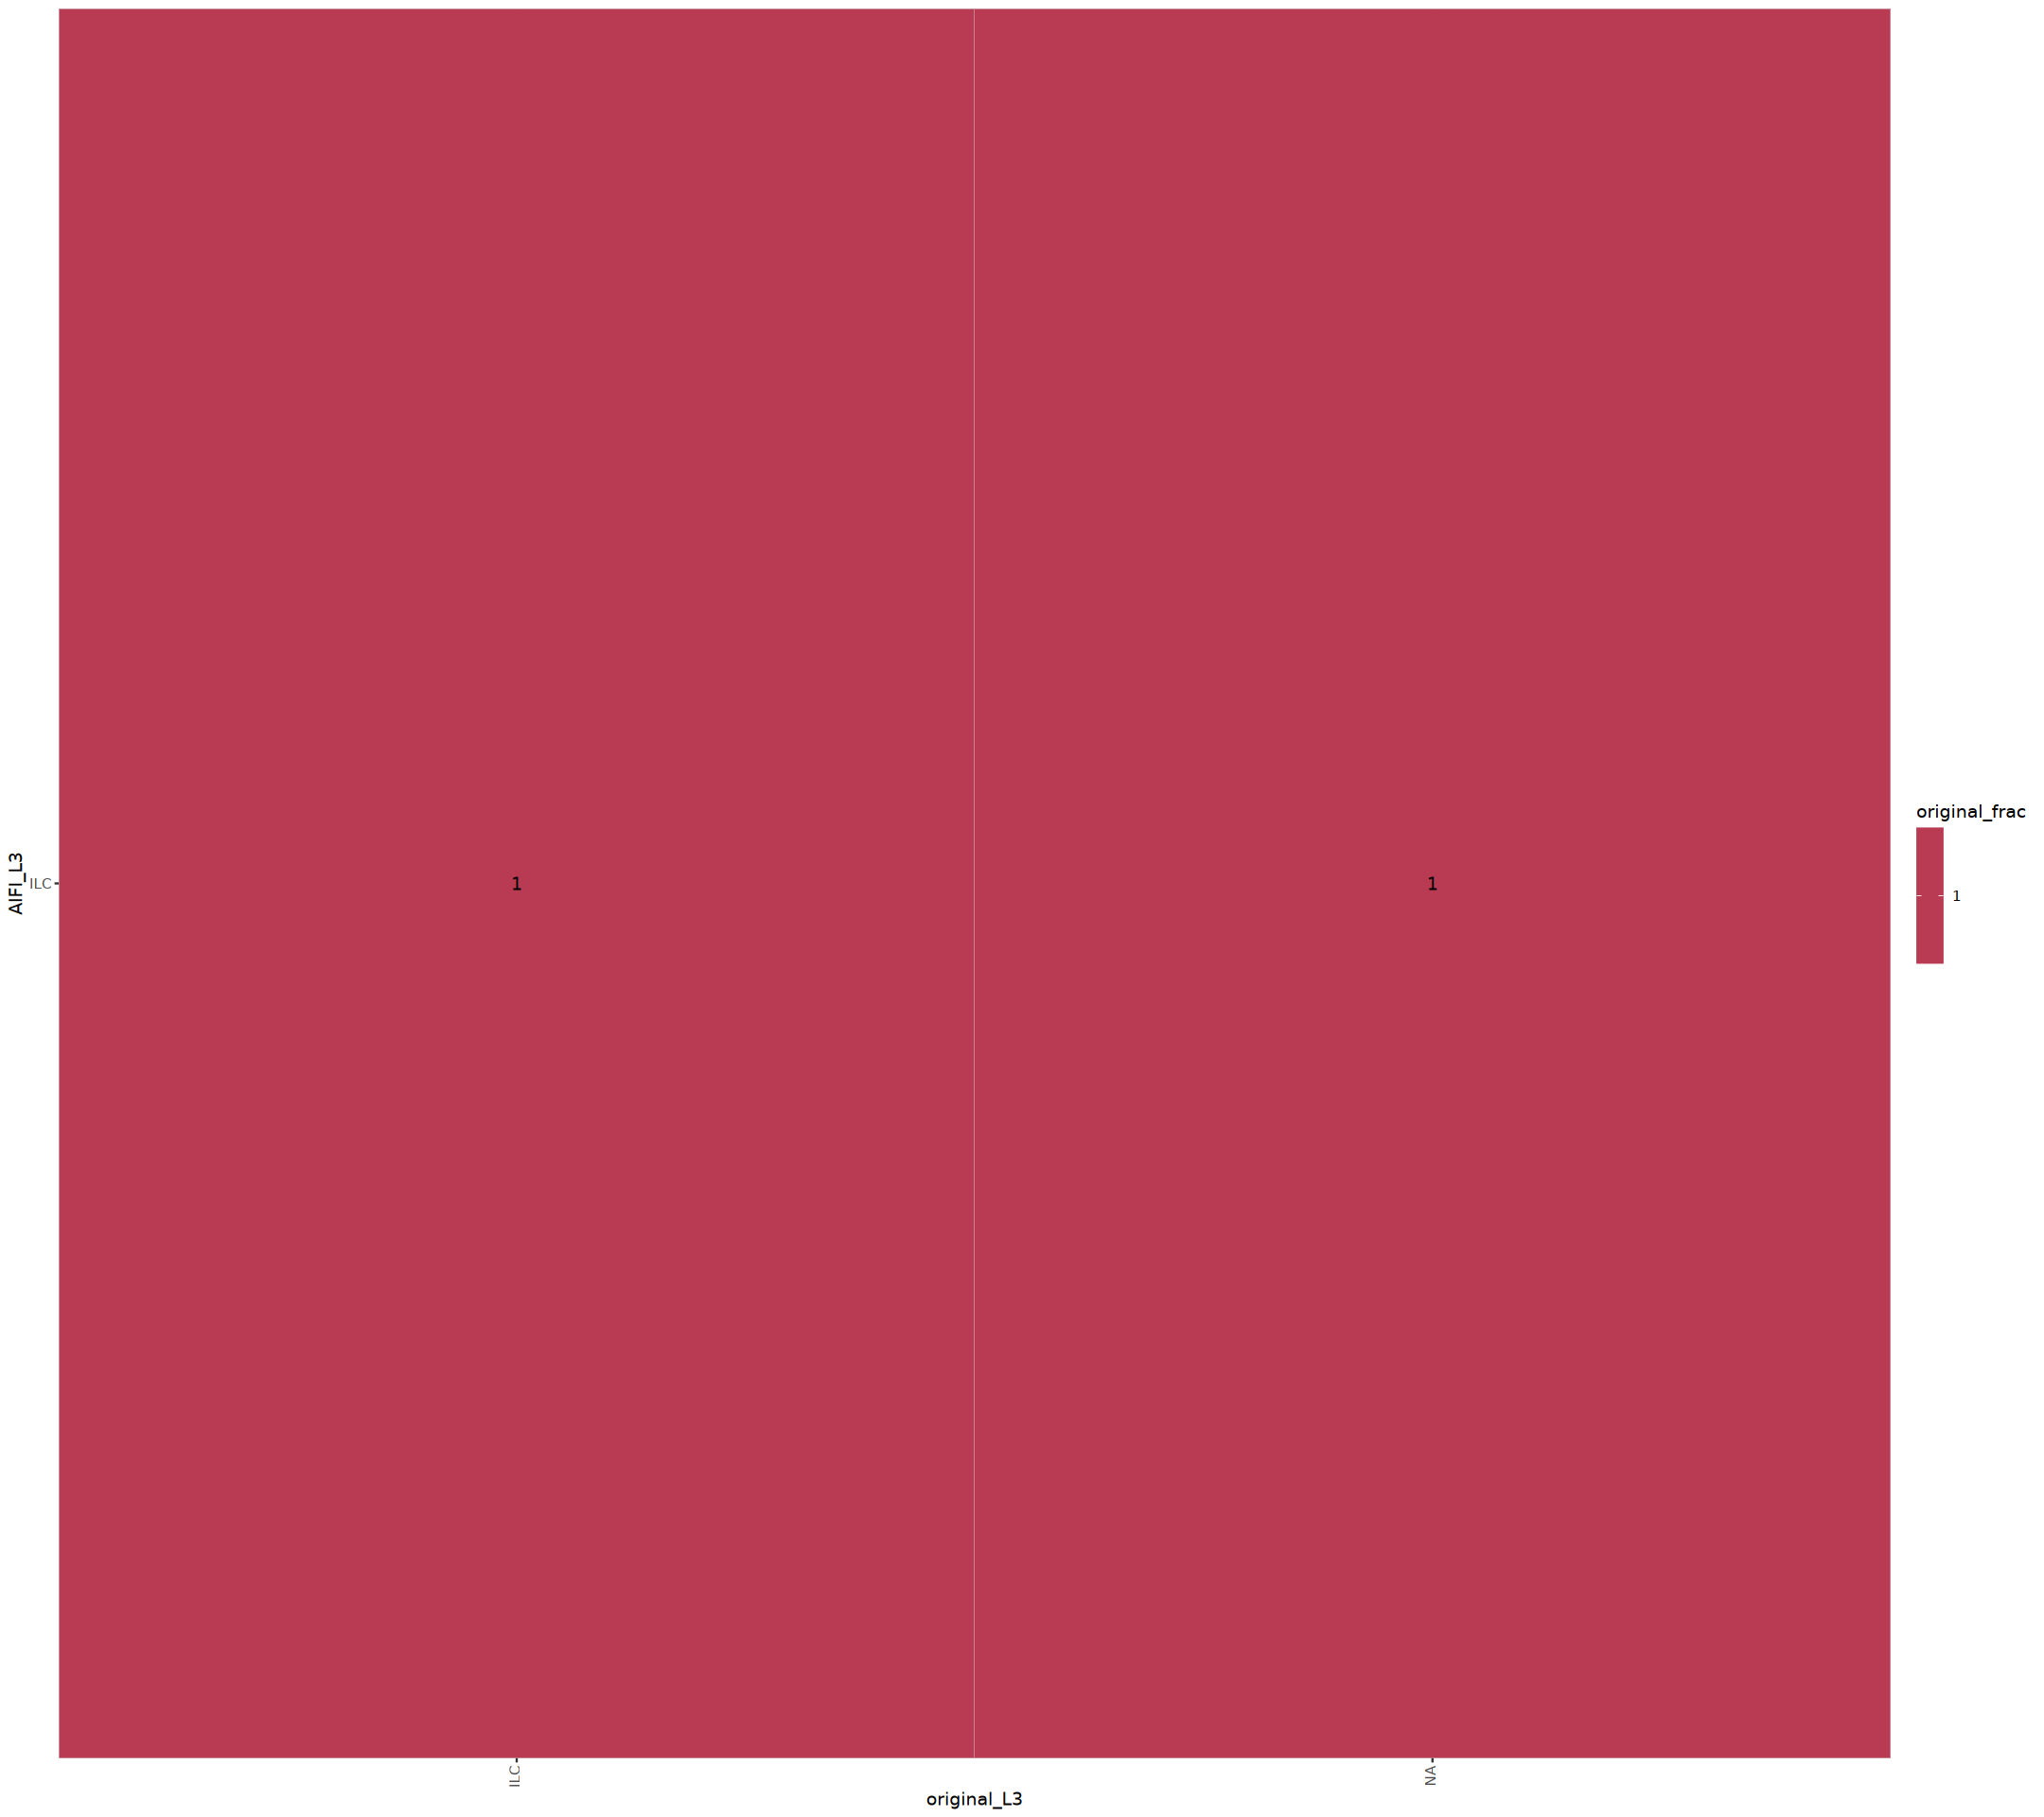

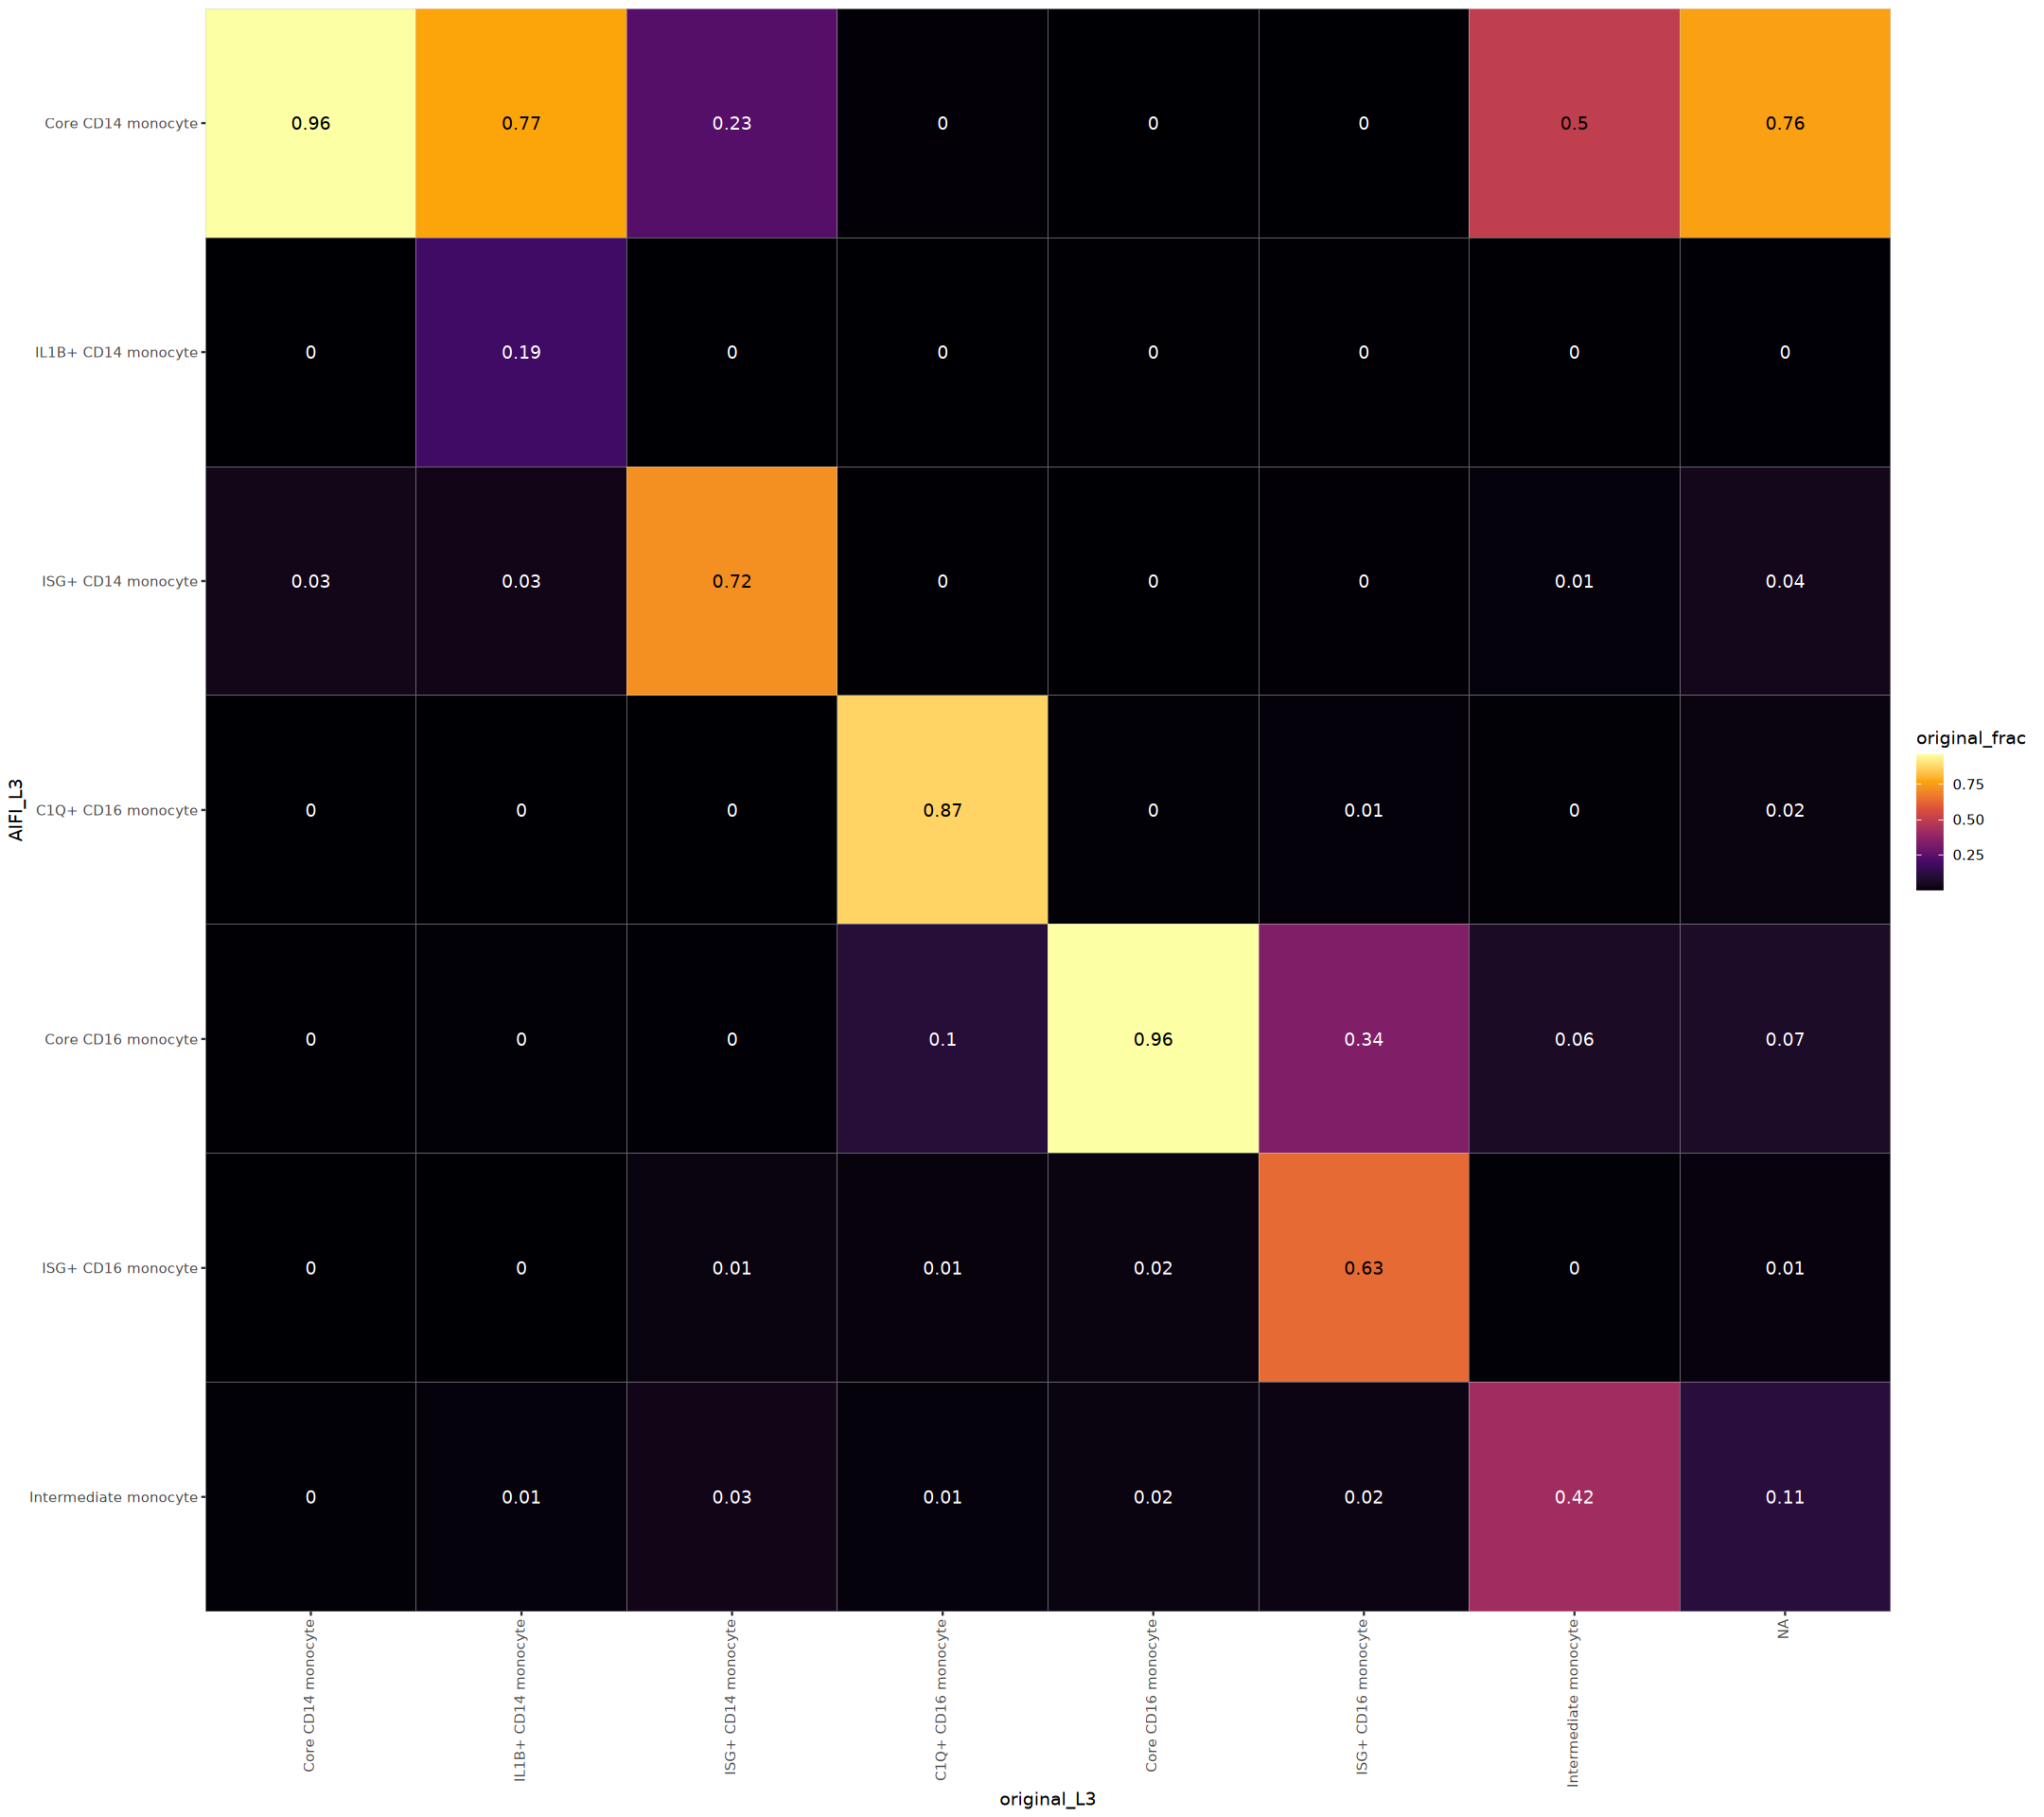

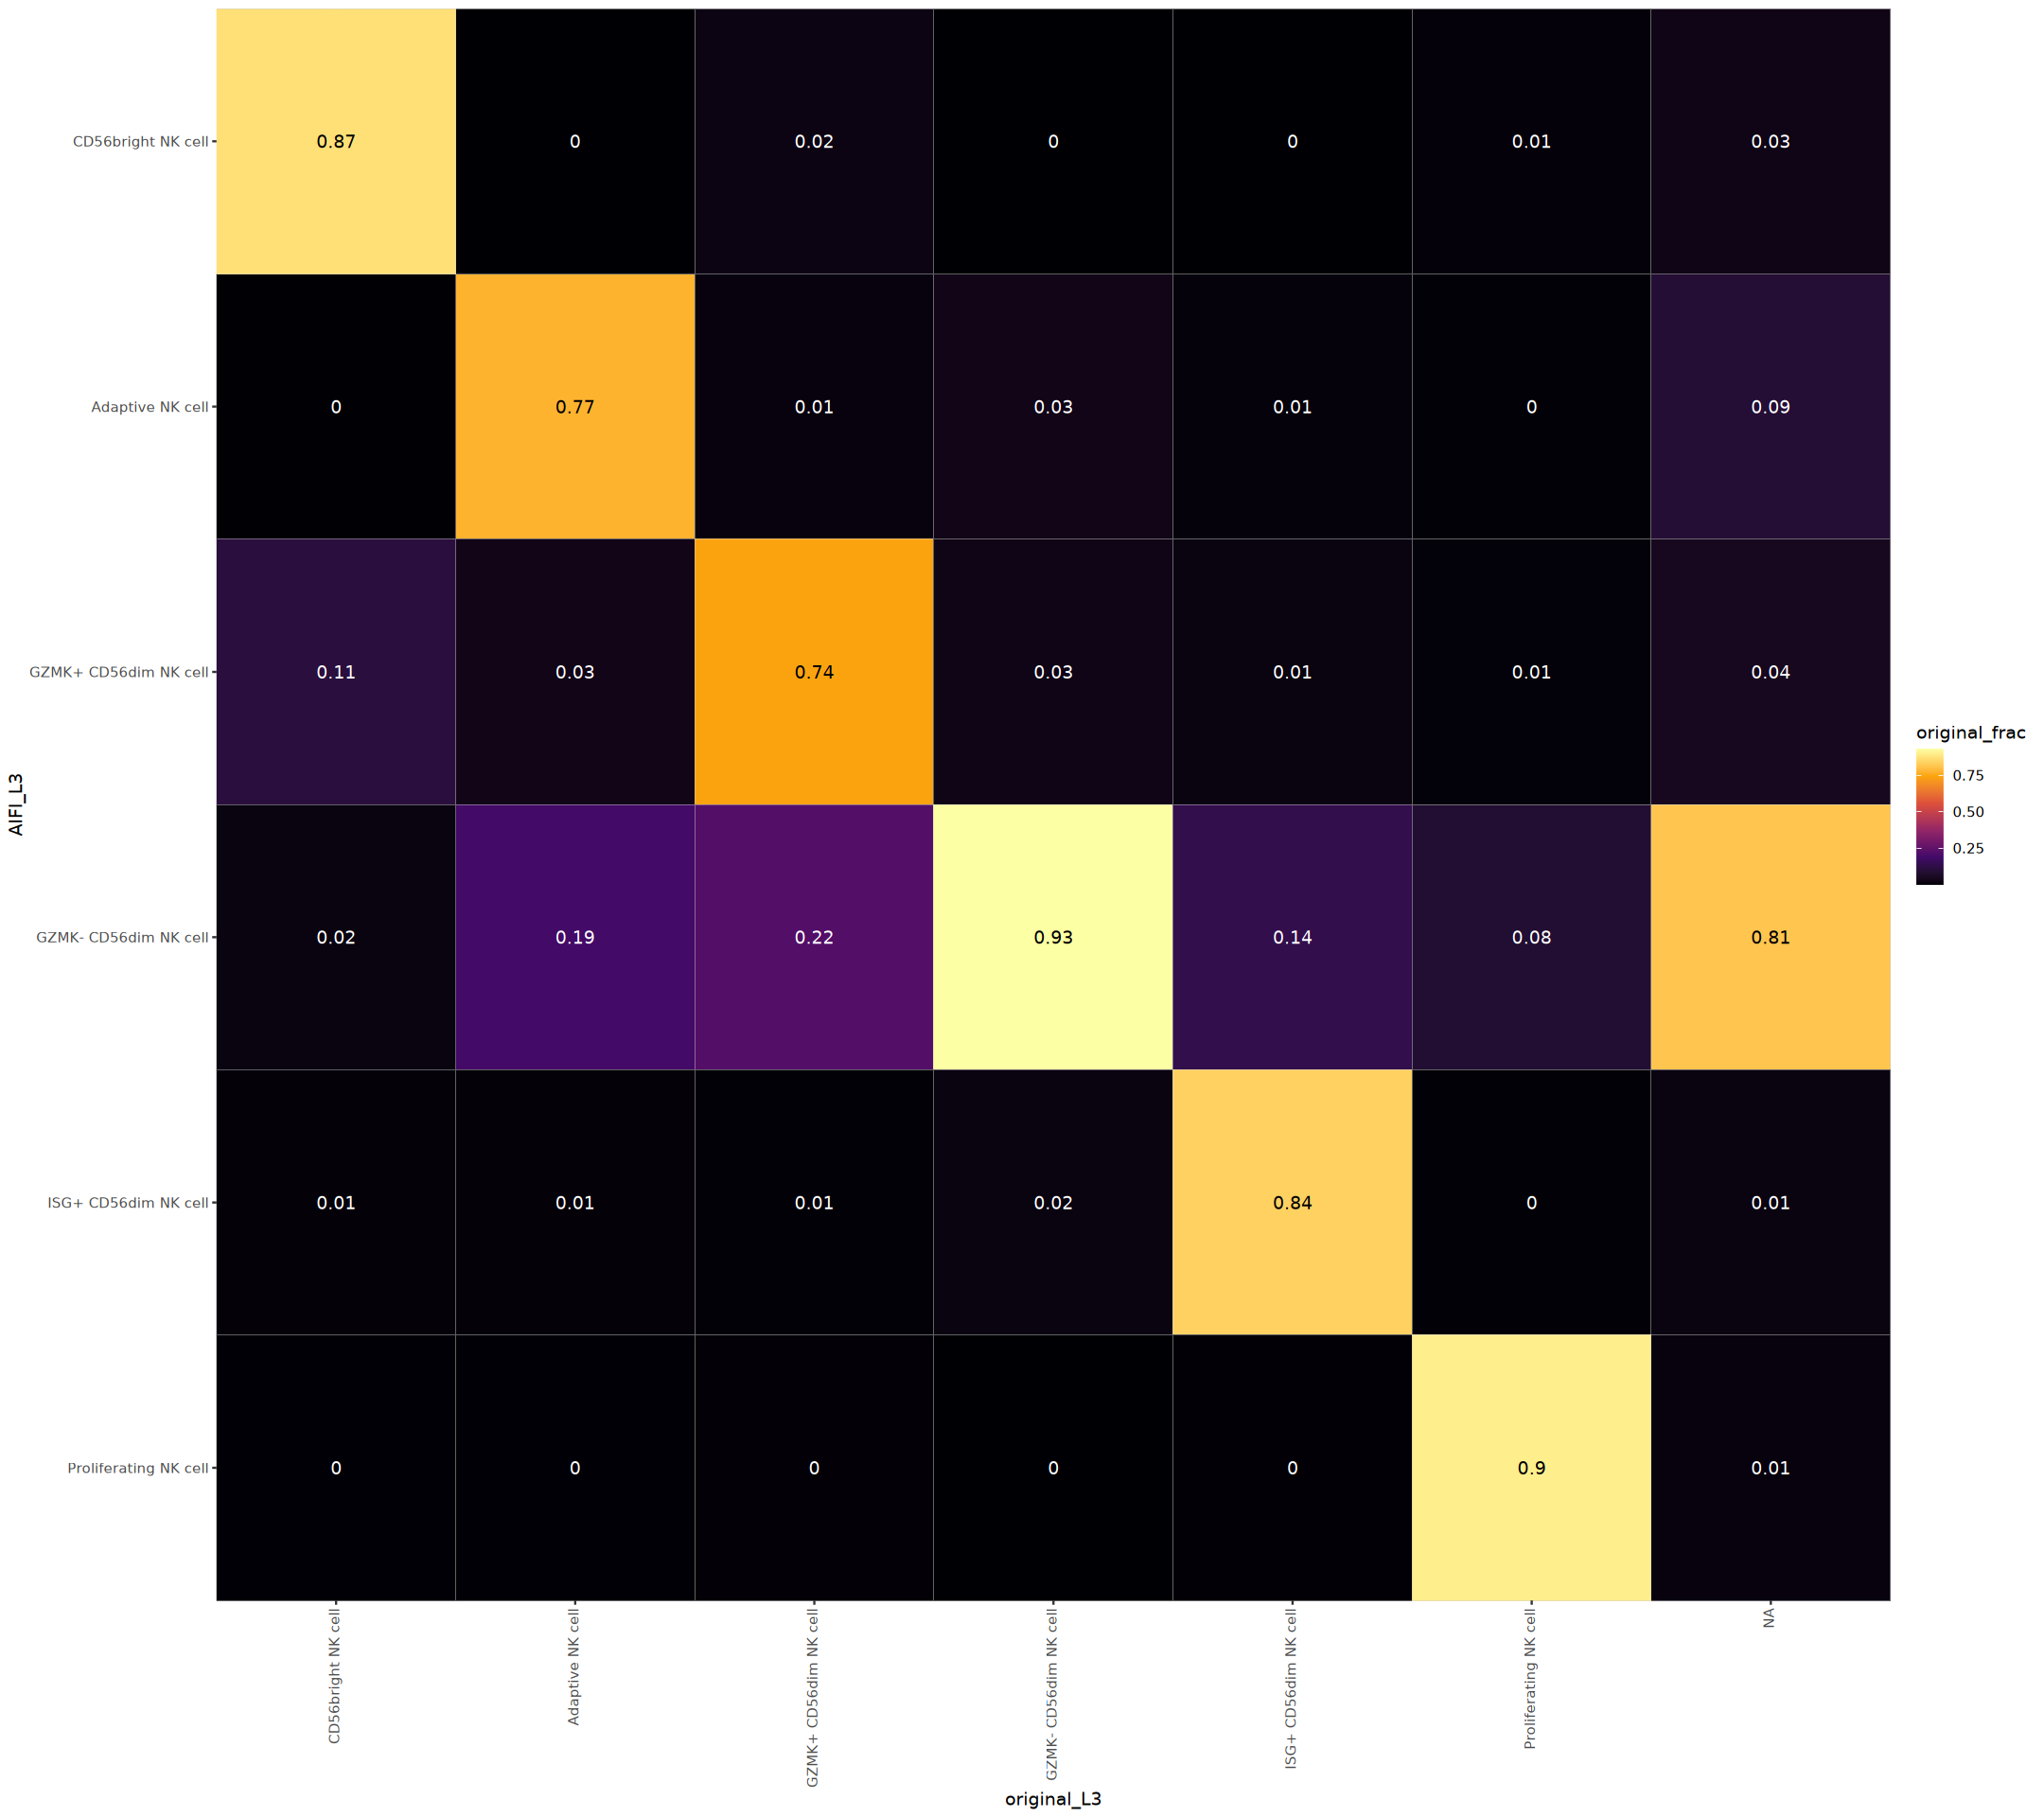

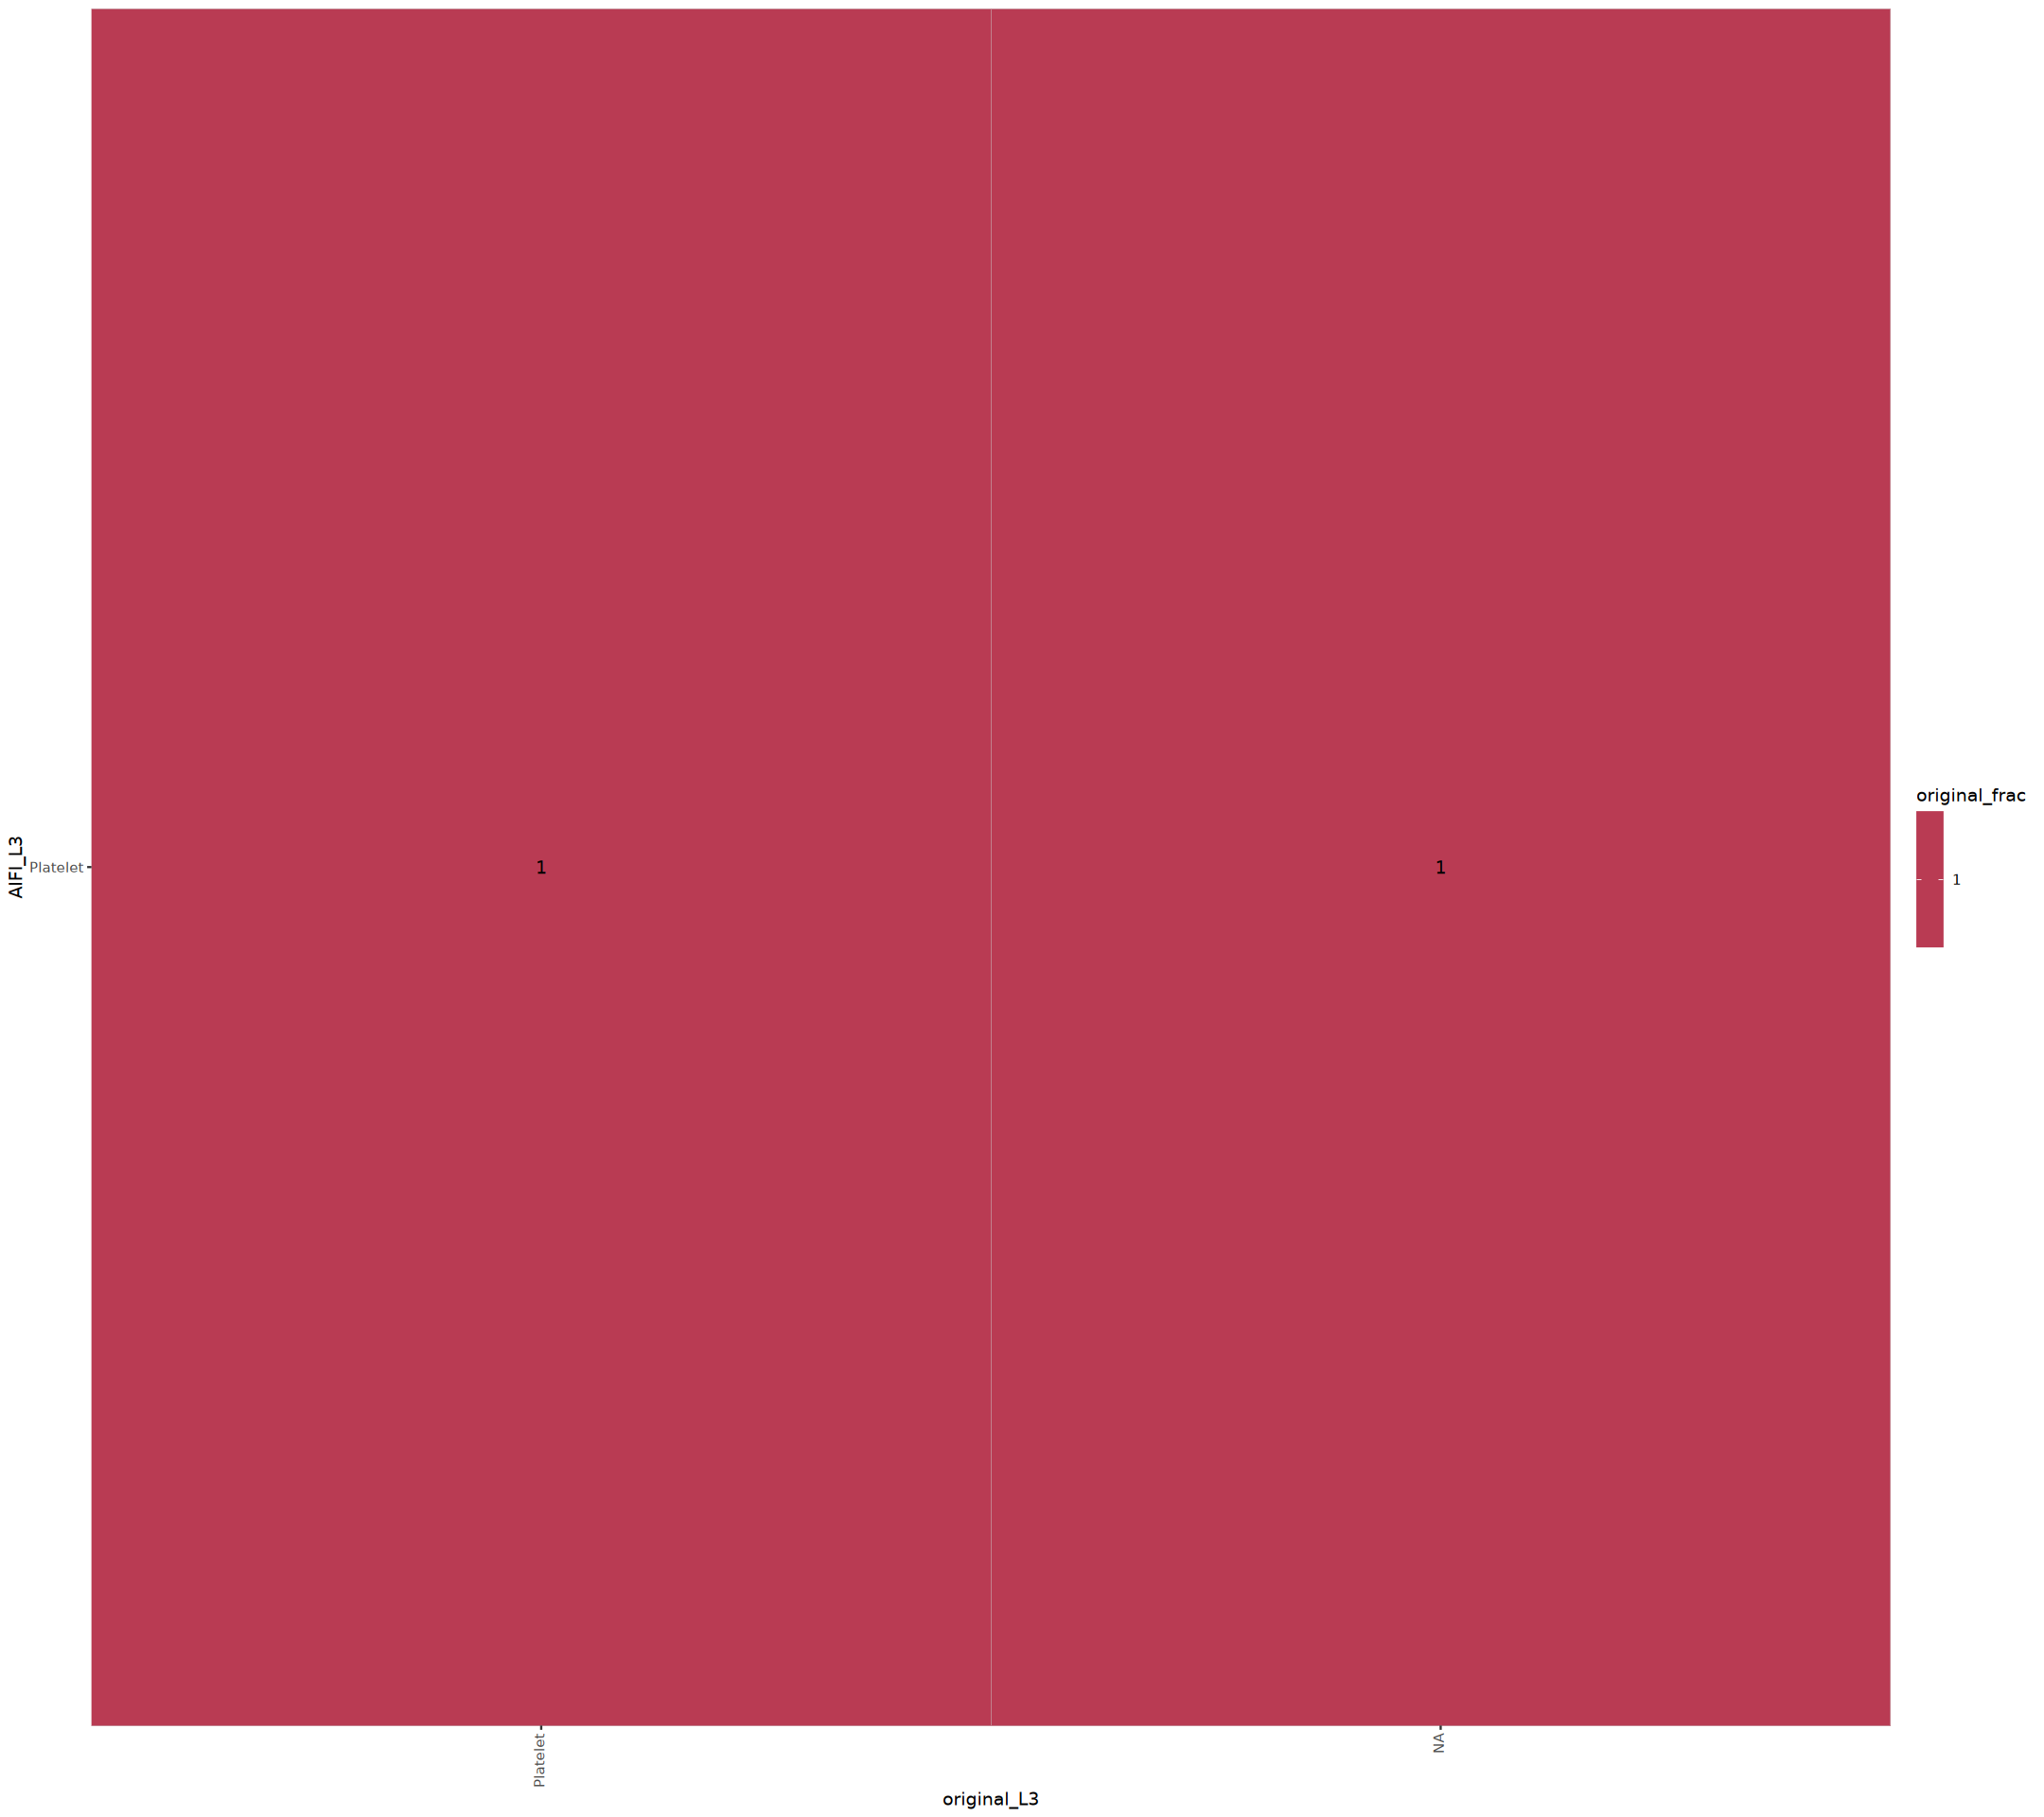

$`B cell`

$DC

$Erythrocyte

$ILC

$Monocyte

$`NK cell`

$Platelet

$`Progenitor cell`

$`T cell`


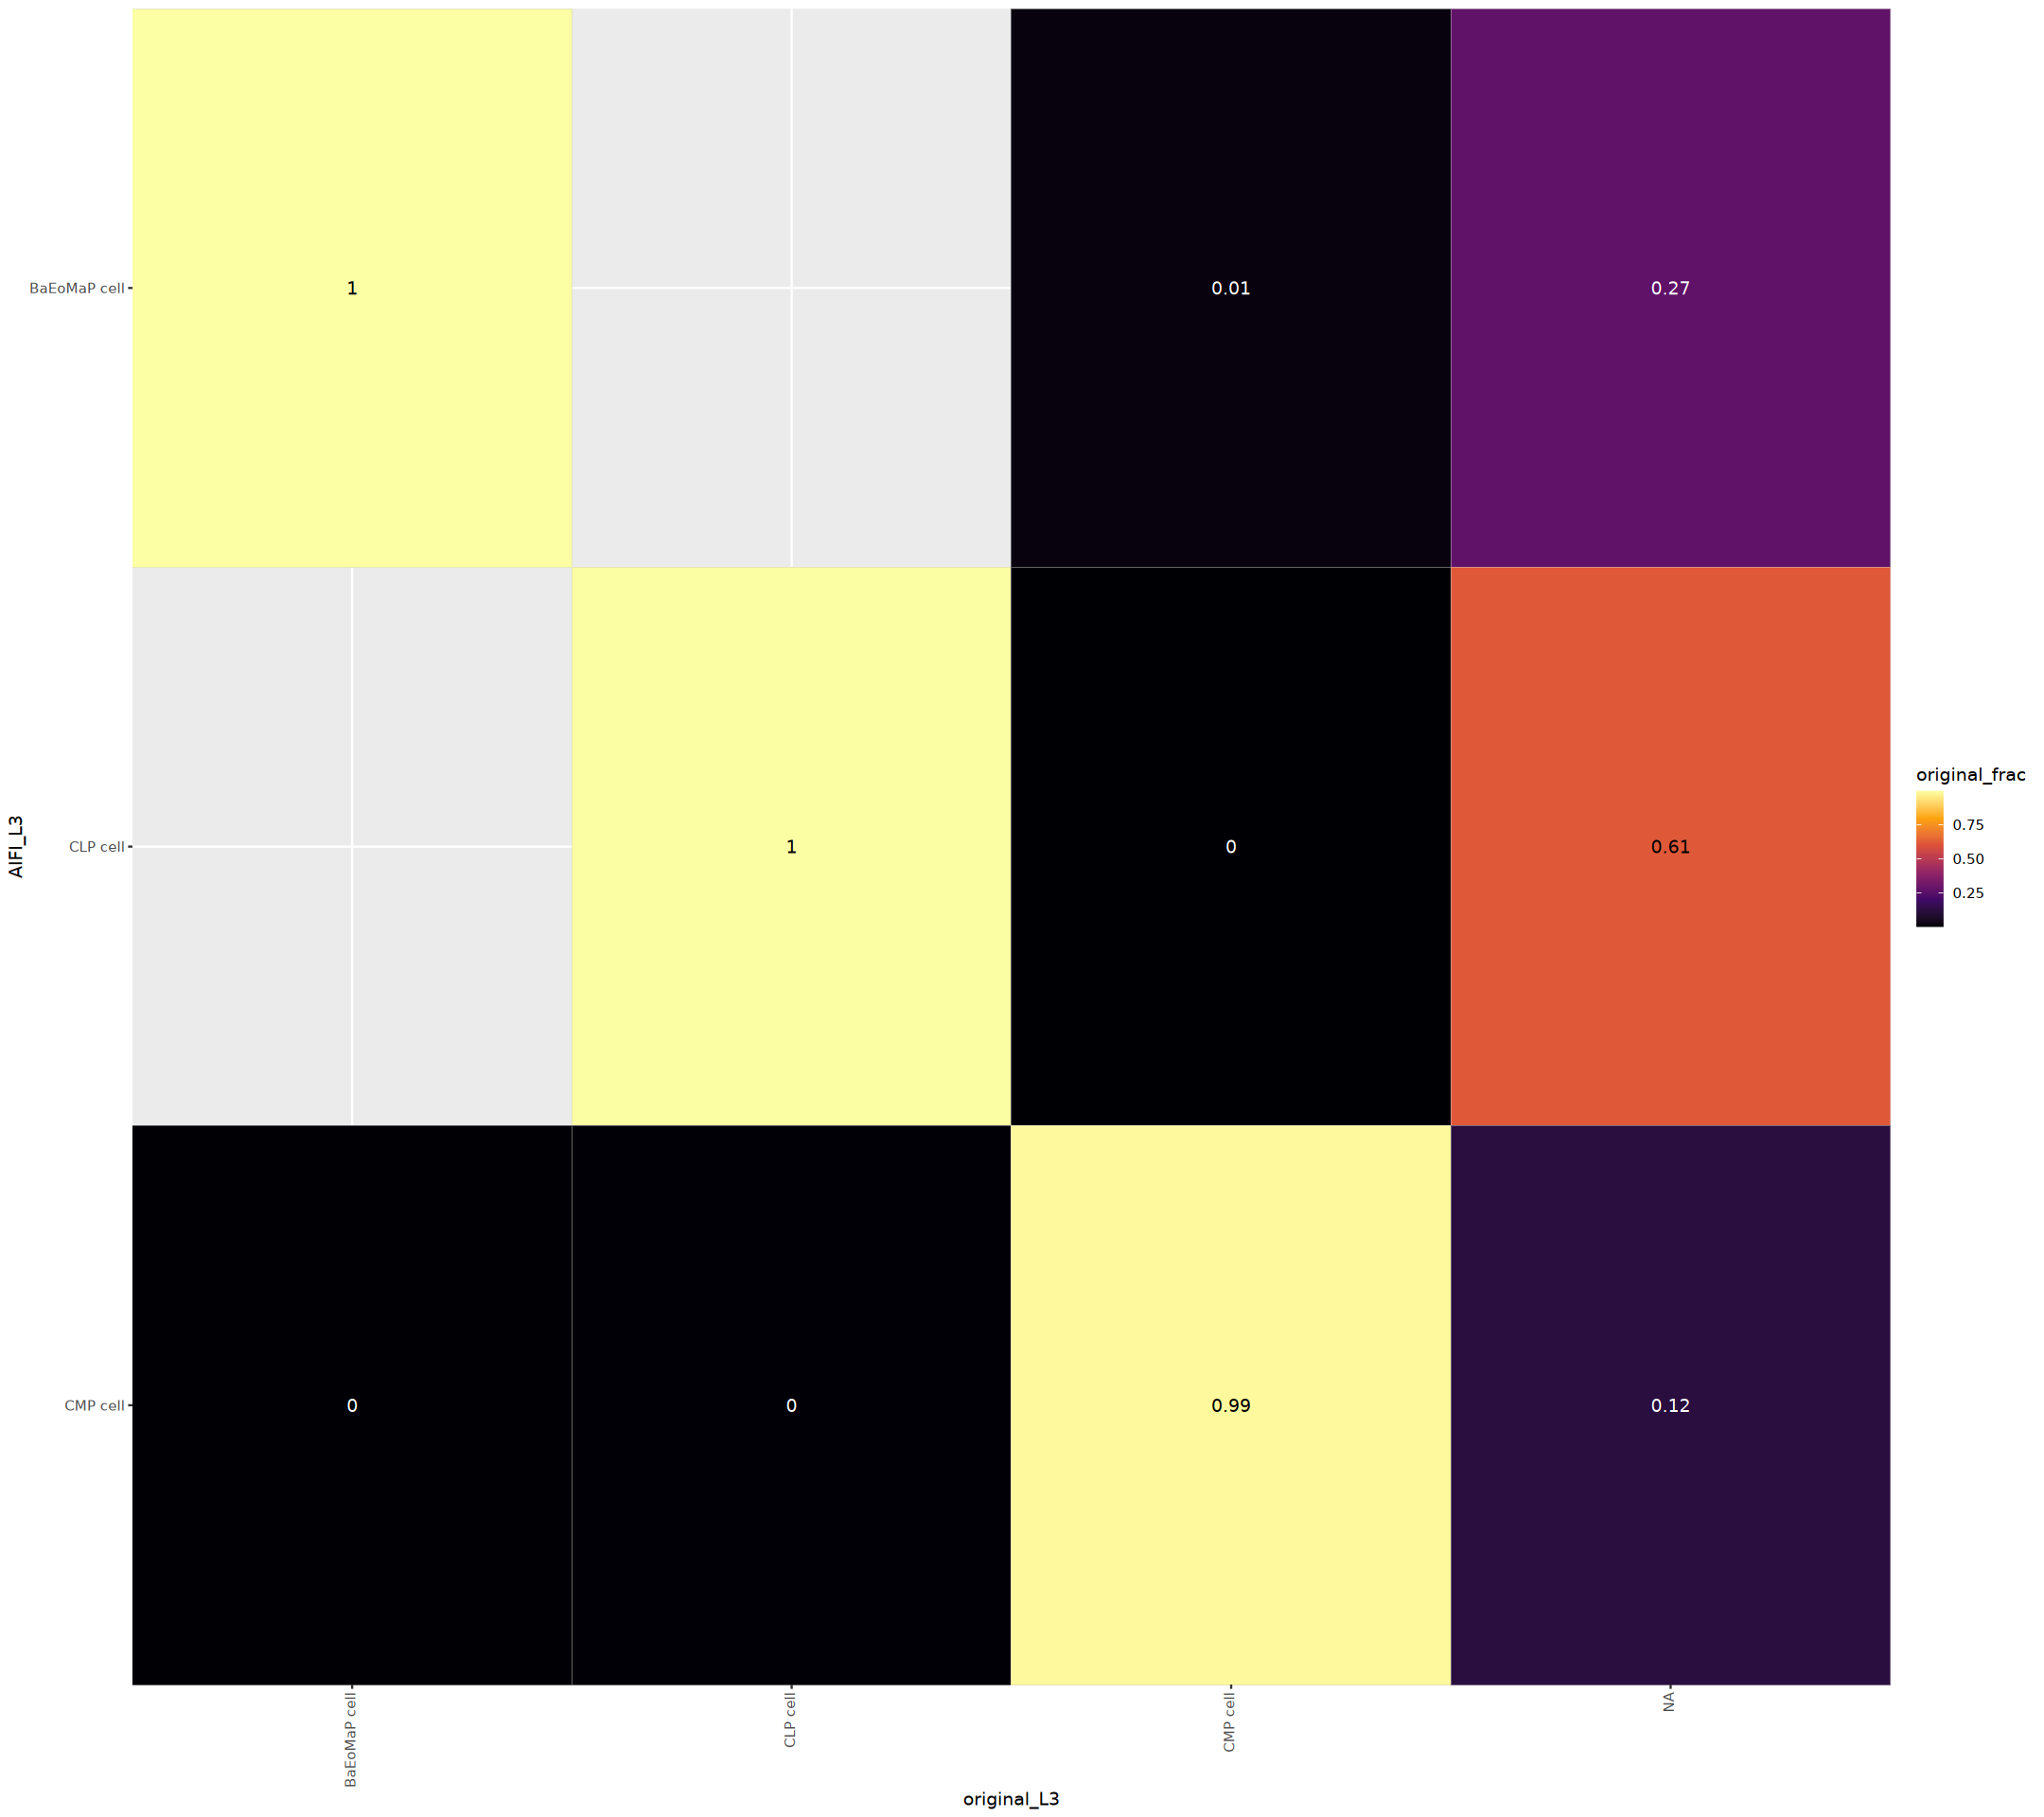

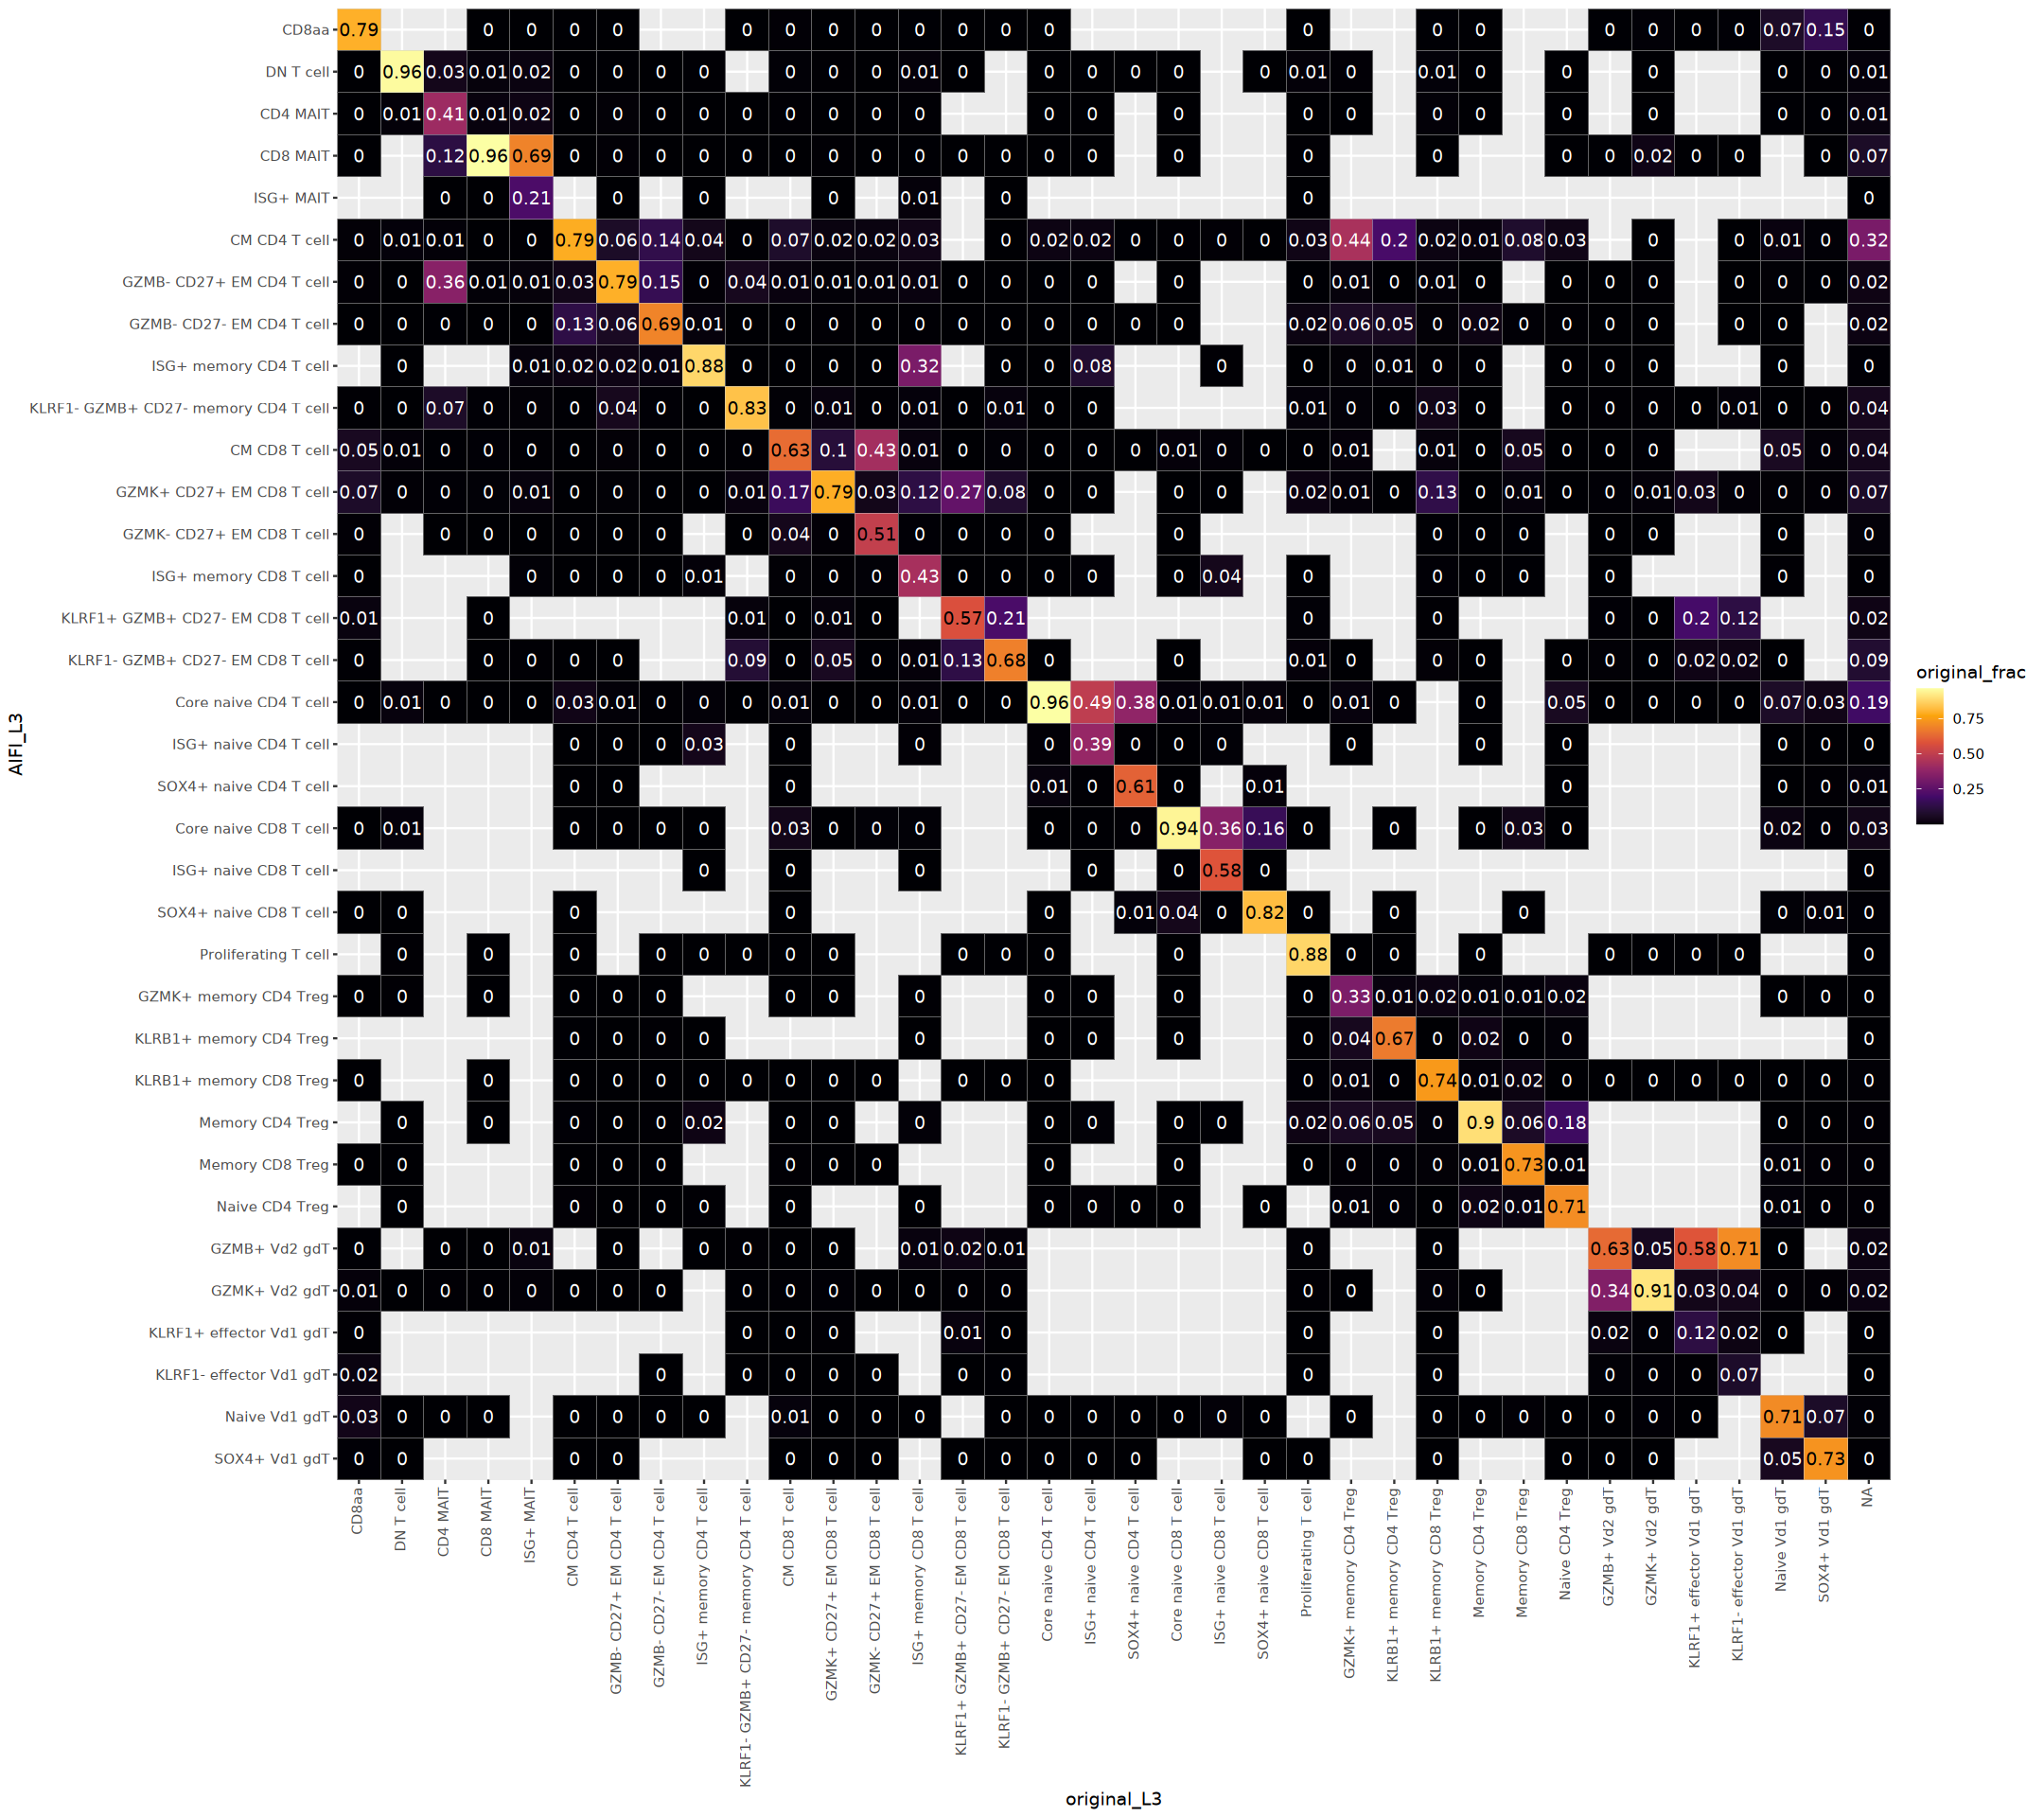

In [40]:
options(repr.plot.width = 18, repr.plot.height = 16)
l1_plots_l3

## Compare predicted and final labels at each level

### L1

In [41]:
l1_crosstab <- all_meta %>%
  group_by(AIFI_L1, predicted_AIFI_L1) %>%
  tally() %>%
  group_by(AIFI_L1) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(predicted_AIFI_L1) %>%
  mutate(predicted_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L1 = factor(AIFI_L1, levels = rev(l1_levels)),
         predicted_AIFI_L1 = factor(predicted_AIFI_L1, levels = l1_levels)) %>%
  mutate(text_color = ifelse(predicted_frac < 0.5, "white", "black"))

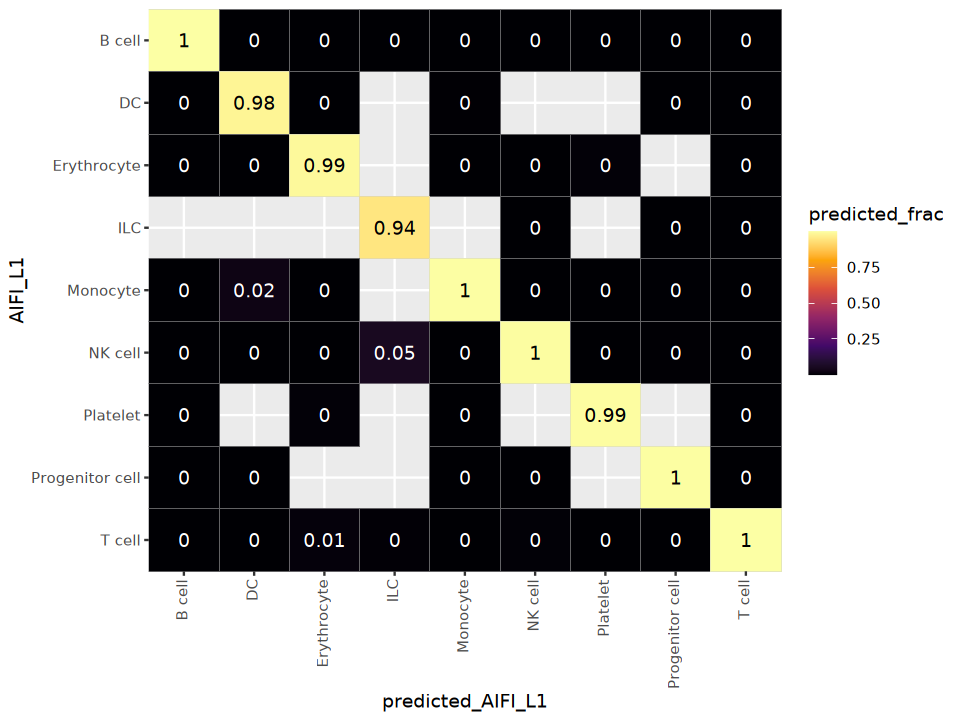

In [42]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() +
  geom_tile(
      data = l1_crosstab,
      aes(x = predicted_AIFI_L1,
          y = AIFI_L1,
          fill = predicted_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l1_crosstab,
      aes(x = predicted_AIFI_L1,
          y = AIFI_L1,
          label = round(predicted_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L2

In [43]:
l2_crosstab <- all_meta %>%
  group_by(AIFI_L2, predicted_AIFI_L2) %>%
  tally() %>%
  group_by(AIFI_L2) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(predicted_AIFI_L2) %>%
  mutate(predicted_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L2 = factor(AIFI_L2, levels = rev(l2_levels)),
         predicted_AIFI_L2 = factor(predicted_AIFI_L2, levels = l2_levels)) %>%
  mutate(text_color = ifelse(predicted_frac < 0.5, "white", "black"))

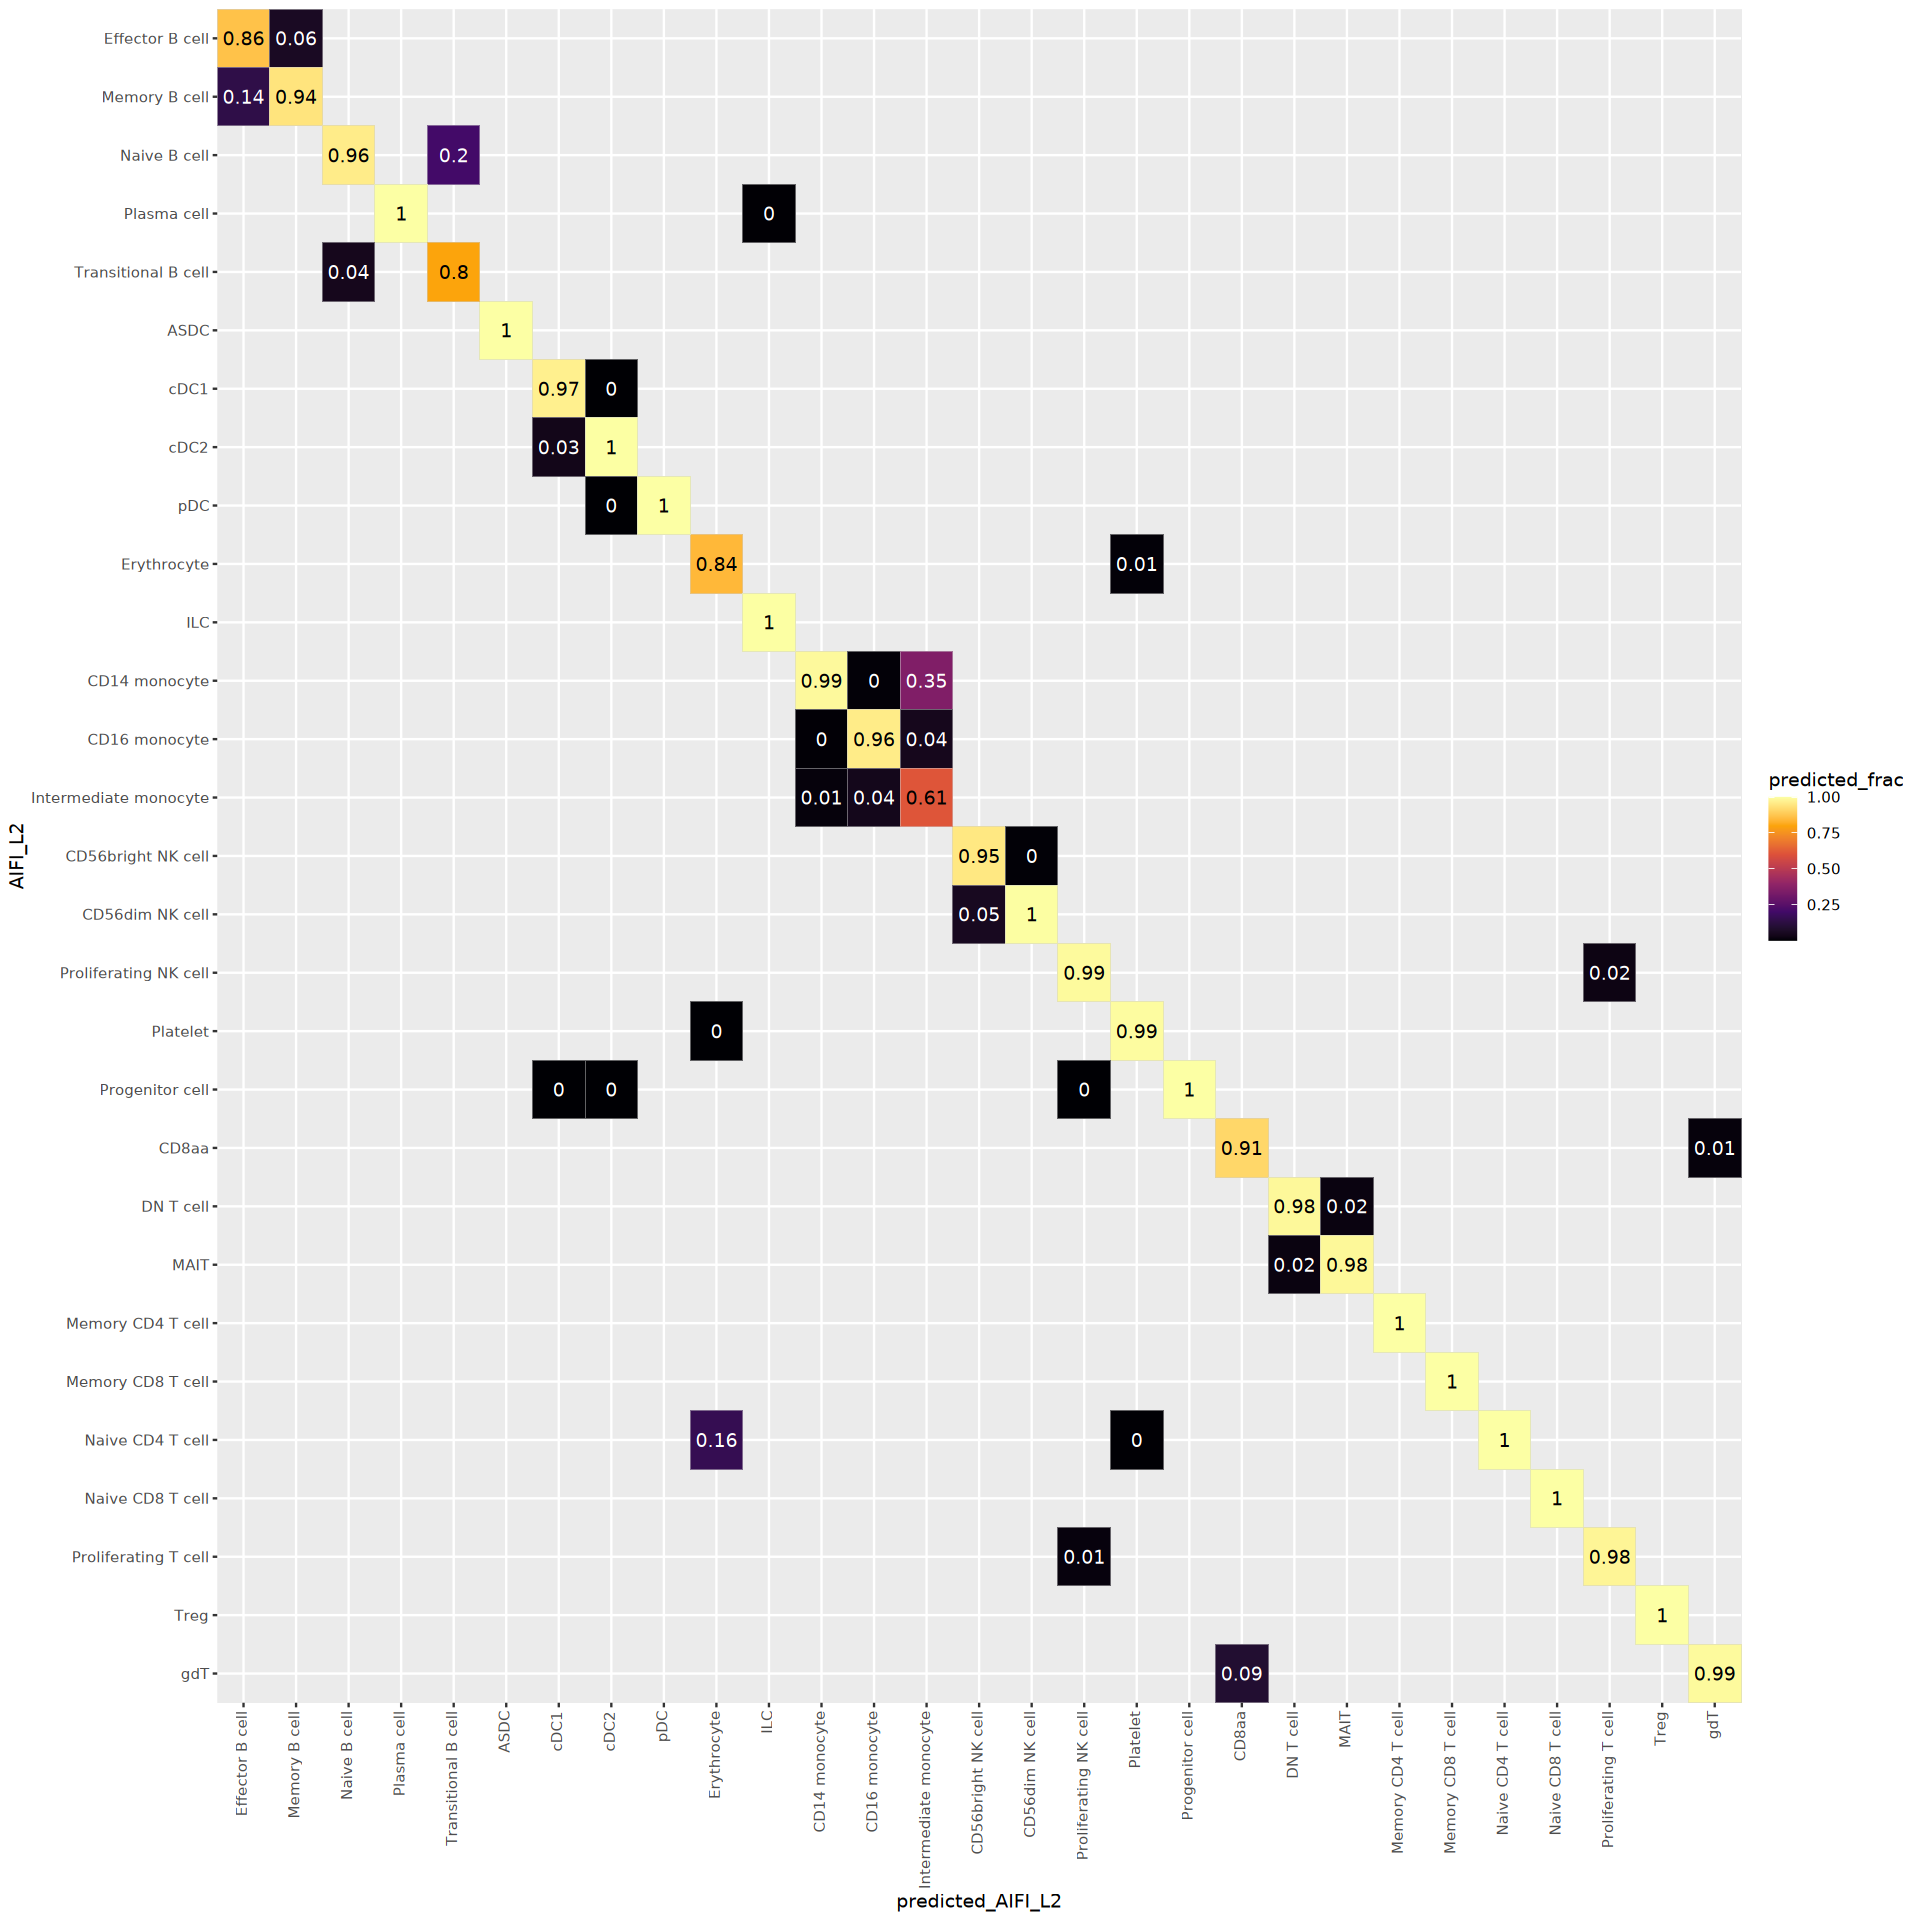

In [44]:
options(repr.plot.width = 16, repr.plot.height = 16)
ggplot() +
  geom_tile(
      data = l2_crosstab,
      aes(x = predicted_AIFI_L2,
          y = AIFI_L2,
          fill = predicted_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l2_crosstab,
      aes(x = predicted_AIFI_L2,
          y = AIFI_L2,
          label = round(predicted_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))

### L3

In [45]:
l3_crosstab <- all_meta %>%
  group_by(AIFI_L3, predicted_AIFI_L3) %>%
  tally() %>%
  group_by(AIFI_L3) %>%
  mutate(AIFI_frac = n / sum(n)) %>%
  group_by(predicted_AIFI_L3) %>%
  mutate(predicted_frac = n / sum(n)) %>%
  ungroup() %>%
  mutate(AIFI_L3 = factor(AIFI_L3, levels = rev(l3_levels)),
         predicted_AIFI_L3 = factor(predicted_AIFI_L3, levels = l3_levels)) %>%
  mutate(text_color = ifelse(predicted_frac < 0.5, "white", "black"))

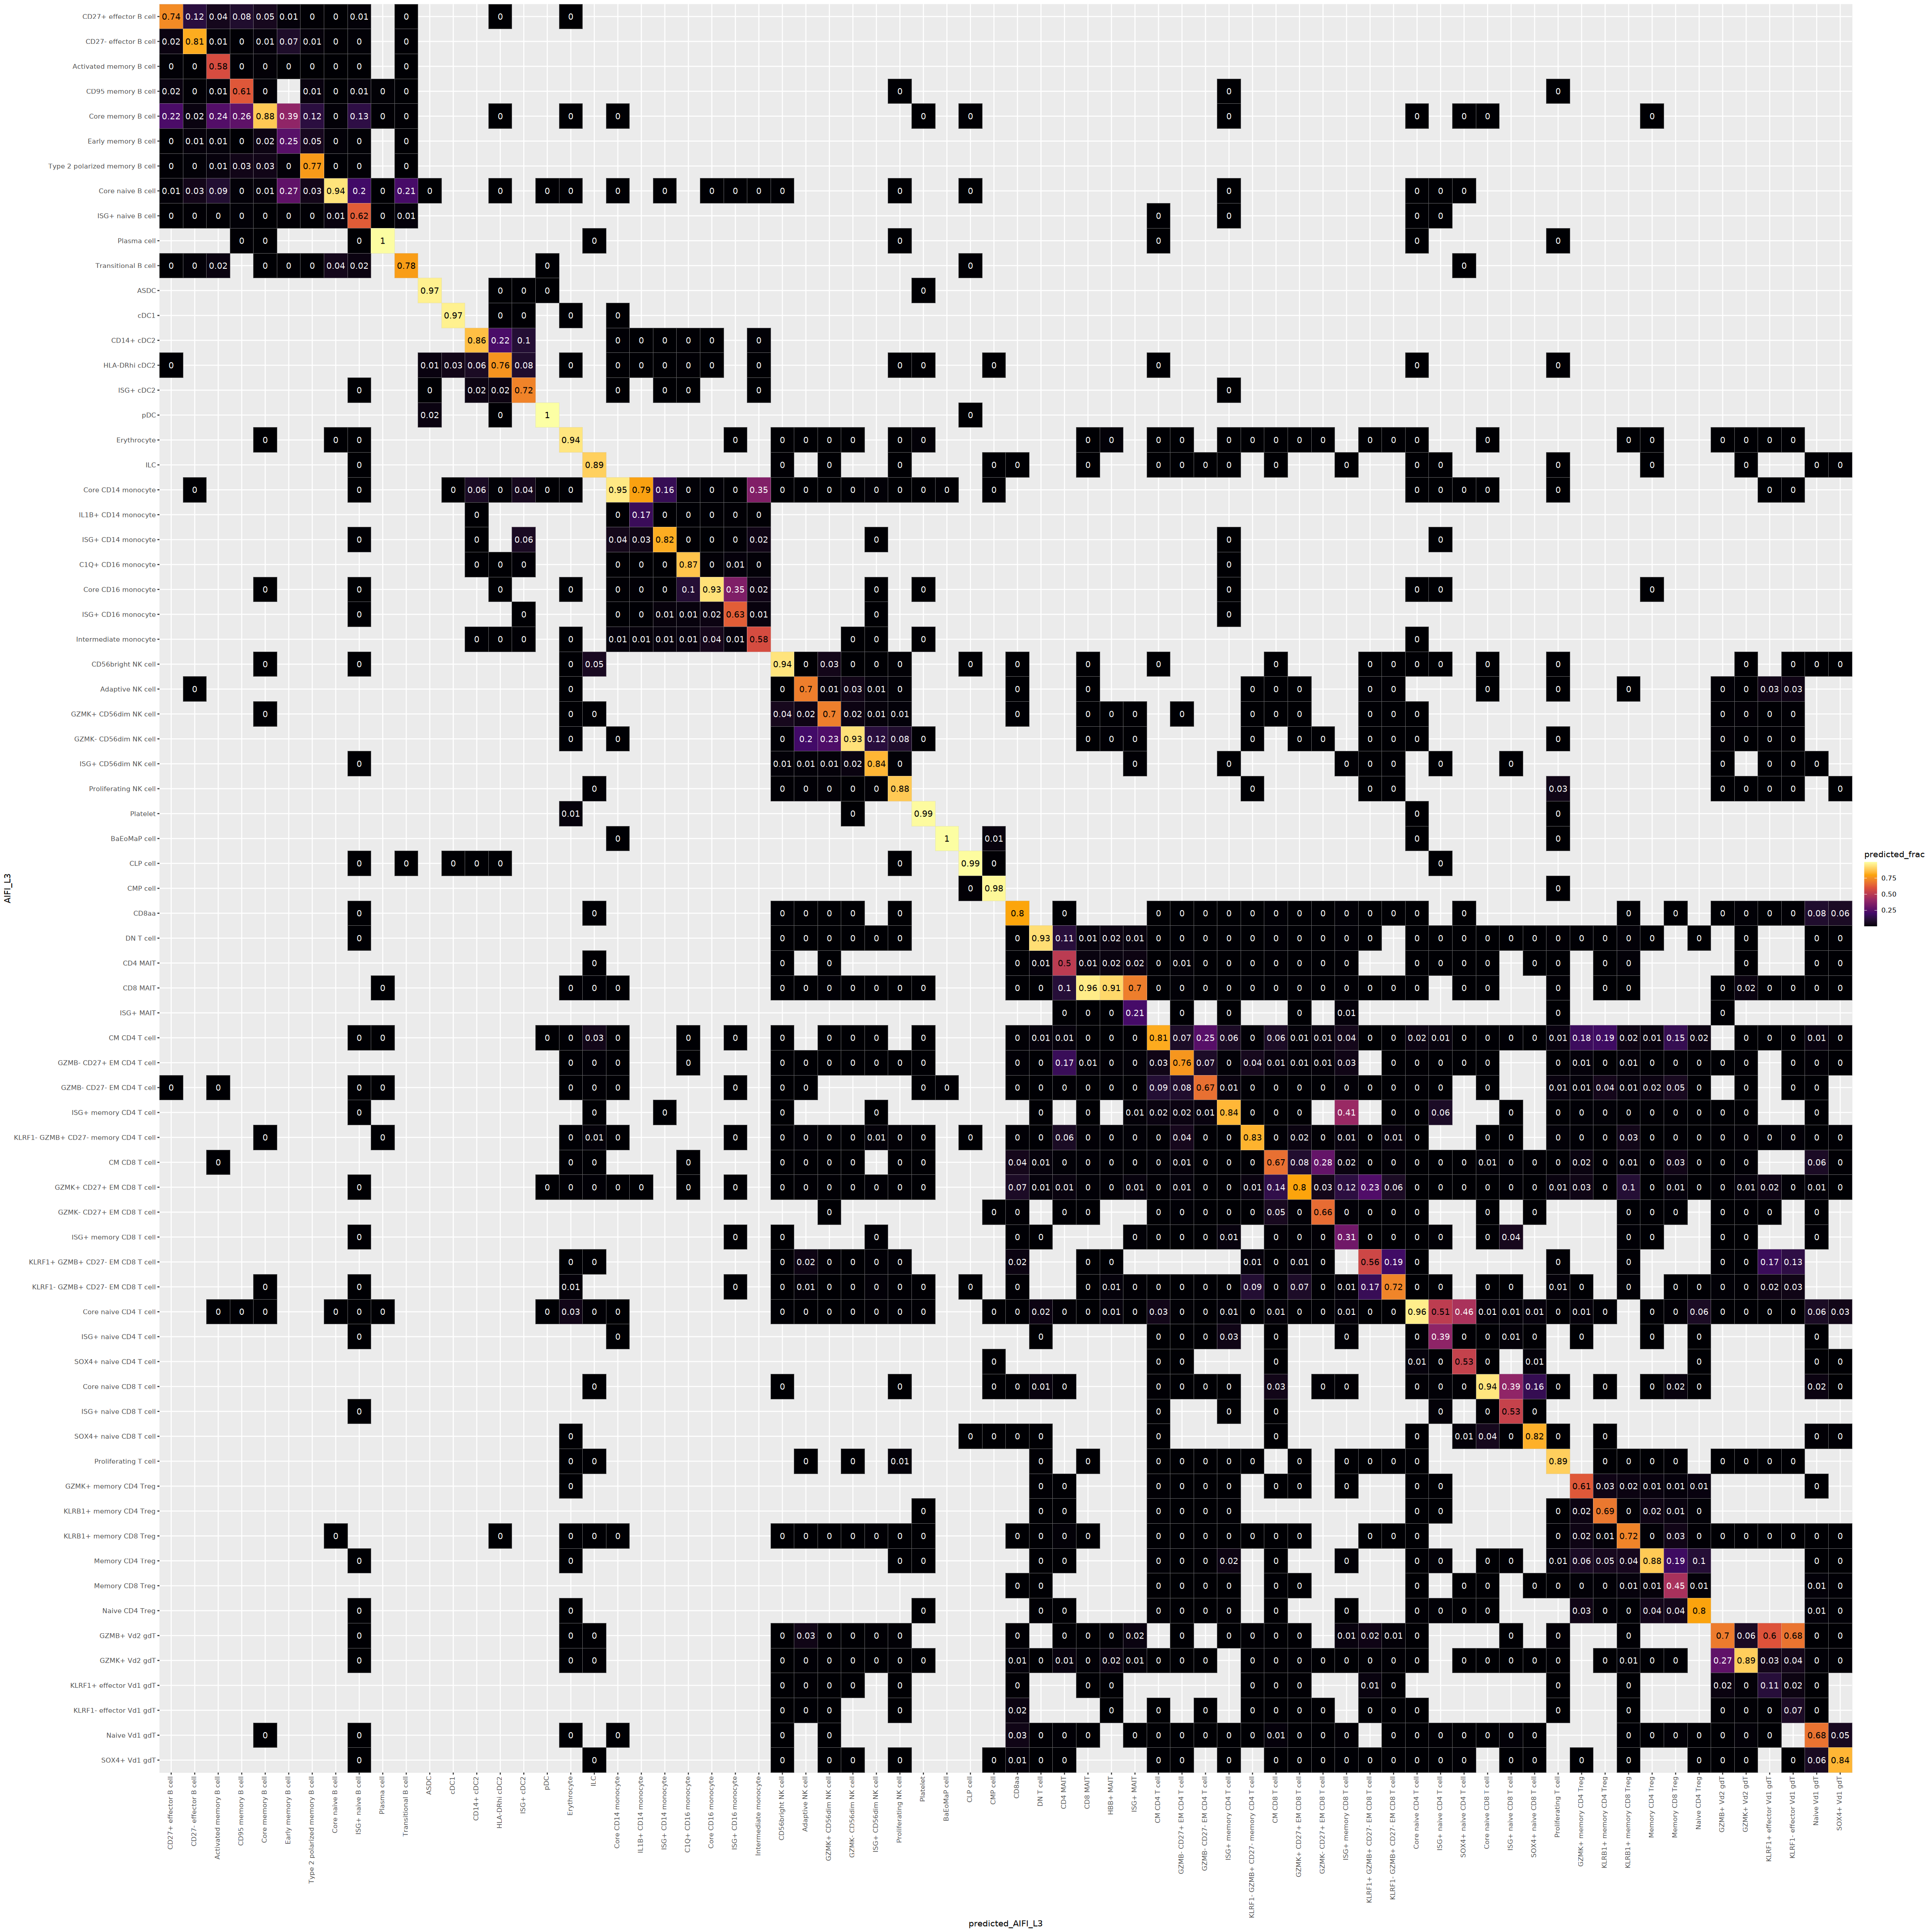

In [46]:
options(repr.plot.width = 36, repr.plot.height = 36)
ggplot() +
  geom_tile(
      data = l3_crosstab,
      aes(x = predicted_AIFI_L3,
          y = AIFI_L3,
          fill = predicted_frac),
      color = "gray80"
  ) +
  geom_text(
      data = l3_crosstab,
      aes(x = predicted_AIFI_L3,
          y = AIFI_L3,
          label = round(predicted_frac,2),
          color = text_color
          )
  ) +
  scale_x_discrete(expand = c(0,0)) +
  scale_y_discrete(expand = c(0,0)) +
  scale_fill_viridis_c(option = "B") +
  scale_color_identity() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3))